# How to Build a State-of-the-Art Machine Learning Model for Chemical Property Prediction

This notebook shows how to build a simple but strong machine-learning model for the prediction of **logP** (water-octanol partition coefficient).   

The **logP** is quite an important property in medicinal and pharmaceutical chemistry, as it relates to the distribution of drugs between aqueous phases (hydrophilic phases such as blood) and other non-aqueous compartments in the human body.

The approach is tested on the recent **SAMPL7 blind challenge** dataset showing excellent results here.

In fact this approach can be used to predict any chemical property as long as their
is enough chemical data for model building, i.e. in the form of several hundred or better thousands SMILES and property pairs.  

**Never** use this approach for small datasets, i.e. use at least a few 100 samples if possible. That is a common mistake i.e. using the machinery of ML on small datasets without doing the due diligent statistics - paving the way for "predictive" models being much to over-confident, which look great in theory and academic papers but failing terribly in real-world practice!

## Used libraries:

* [RDKit](https://www.rdkit.org/)
* [lightgbm](https://lightgbm.readthedocs.io/en/latest/)
* [pandas](https://pandas.pydata.org/)
* [scikit-learn](https://scikit-learn.org/stable/)

## Used data:

* [Opera curated physprop dataset(s)](https://epa.figshare.com/articles/dataset/PHYSPROP_Analysis_File_12_14_2016/5588578/2)
* [SAMPL7 logP blind challenge data](https://github.com/samplchallenges/SAMPL7)

# Overview & individual steps

1. [Load experimental data](#Loading-the-data)
2. [Compute descriptors](#Computing-descriptors)
3. [Compute fingerprints](#Computing-fingerprints-as-descriptors)
4. [Model building](#Model-training)
5. [Parameter selection](#Parameter-selection)
6. [Deployment & Analysis](#Deployment-&-Analysis-of-the-results)

In [82]:
# technical & general libraries
from tqdm.notebook import tqdm

# data science libraries
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import KFold,cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

from joblib import dump, load

# cheminformatics
from rdkit.Chem import AllChem as Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# set some options for better visibility of DataFrames
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

## Loading the data

We start with loading training and test set data from [SD files](https://en.wikipedia.org/wiki/Chemical_table_file). Those files contain the molecular structure and the corresponding chemical property, here the logP value. The data can be found as an updated version [here](https://github.com/kmansouri/OPERA) and the original published data [here](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0263-1#Sec23).
We use a built-in library from RDKit to create a list of molecules and logP value pairs from it, in total more than 10000 samples.  

Those pairs a save in a list of dictionaries which can then be used to create a pandas dataframe from it.
The pandas DataFrame is a very useful data structure which allows easy handling of tabular data like this.  


For now we use only the provided training data, there is also another SD file with test data, which we leave aside completety for now and which could be used later on to finally test the results.

Lets start with downloading the data from the github repository:

In [83]:
!wget -O ./opera_data.zip https://ndownloader.figstatic.com/files/10692997
#!wget -O ./opera_data.zip https://github.com/kmansouri/OPERA/blob/master/OPERA_Data.zip?raw=true # github data
!unzip ./opera_data.zip

--2020-11-21 18:04:01--  https://ndownloader.figstatic.com/files/10692997
Resolving ndownloader.figstatic.com (ndownloader.figstatic.com)... 34.246.107.109, 34.246.25.17
Connecting to ndownloader.figstatic.com (ndownloader.figstatic.com)|34.246.107.109|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pstorage-npg-968563215/10692997/13321_2018_263_MOESM1_ESM.zip [following]
--2020-11-21 18:04:01--  https://s3-eu-west-1.amazonaws.com/pstorage-npg-968563215/10692997/13321_2018_263_MOESM1_ESM.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.89.51
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.89.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15303706 (15M) [binary/octet-stream]
Saving to: ‘./opera_data.zip’

./opera_data.zip    100%[===================>]  14.59M   849KB/s    in 18s     

2020-11-21 18:04:19 (829 KB/s) - ‘./opera_data.zi

We start with creating a DataFrame from the downloaded SD file, because later on we can more easily work with the data in such a DataFrame.   
We ignore for now also some error message coming from parsing the molecular structures.

In [113]:
sd_file = './OPERA_LogP/TR_LogP_10537.sdf'
#sd_file = './LogP_QR.sdf' # github data
suppl = Chem.SDMolSupplier(sd_file)
data = []
for m in tqdm(suppl):
    if m is None: continue
    smiles = Chem.MolToSmiles(m)
    data.append({'SMILES': smiles, 'logP': m.GetProp('LogP')})

df = pd.DataFrame(data) 
df['logP'] = df['logP'].astype(float) # convert from string to float
df

RDKit ERROR: [18:05:29] ERROR: Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [19:19:22] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [19:19:22] ERROR: Could not sanitize molecule ending on line 146438
RDKit ERROR: [19:19:22] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [19:19:22] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [19:19:22] ERROR: Could not sanitize molecule ending on line 233170
RDKit ERROR: [19:19:22] ERROR: Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [19:19:23] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [19:19:23] ERROR: Could not sanitize molecule ending on line 400722
RDKit ERROR: [19:19:23] ERROR: Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [19:19:23] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [19:19:23] ERROR: Could not 

RDKit ERROR: [19:19:23] ERROR: Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [19:19:24] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [19:19:24] ERROR: Could not sanitize molecule ending on line 794656
RDKit ERROR: [19:19:24] ERROR: Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [19:19:24] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [19:19:24] ERROR: Could not sanitize molecule ending on line 794744
RDKit ERROR: [19:19:24] ERROR: Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [19:19:24] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [19:19:24] ERROR: Could not sanitize molecule ending on line 950133
RDKit ERROR: [19:19:24] ERROR: Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [19:19:24] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [19:19:24] ERROR: Could no

,SMILES,logP
0,C=O,0.35
1,CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O)C(=O)CO,1.83
2,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(O)CC21C,2.19
3,CCC1(c2ccccc2)C(=O)NC(=O)NC1=O,1.47
4,COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(N)C3=O)N1CC1NC12,-0.40
...,...,...
10522,Brc1ccc(Oc2ccc(Br)c(Br)c2Br)c(Br)c1,7.37
10523,Brc1ccc(Oc2cc(Br)c(Br)cc2Br)c(Br)c1,7.32
10524,Brc1ccc(Oc2c(Br)cc(Br)cc2Br)c(Br)c1,7.24
10525,Brc1cc(Br)c(Oc2cc(Br)c(Br)cc2Br)c(Br)c1,7.82


Now we have a pandas DataFrame with SMILES, encoding the molecular topology, and experimental logP values.

## Computing descriptors

RDKit provides a nice tool to compute any kind of descriptors:

In [85]:
calculator = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
calculator.GetDescriptorNames()

('MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA8',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_V

Lets understand how the descriptor calculator from RDKit works.  
It takes a molecule and returns a `tuple` 
of all RDKit descriptors for this molecule, 200 in total.

In [86]:
calculator.CalcDescriptors??

In [87]:
len(calculator.CalcDescriptors(Chem.MolFromSmiles("CCO")))

200

In [88]:
def smiles2desc(s):
    descriptors = calculator.CalcDescriptors(Chem.MolFromSmiles(s))
    return descriptors

Lets first create a pandas series and then turn this (pandas) series of tuples into a pandas DataFrame containing all descriptors. This might take a while...   
Certainly we do not need all of those descriptors. Later we will find a way to select the descriptors we need.

We then save the DataFrame for later use and save some time during model development.

In [89]:
%%time
desc_tuples = df['SMILES'].apply(smiles2desc)
X = pd.DataFrame(desc_tuples.tolist(), columns = calculator.GetDescriptorNames())
X

CPU times: user 1min 12s, sys: 1.54 s, total: 1min 13s
Wall time: 1min 12s


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,8.000000,2.000000,8.000000,2.000000,0.360624,30.026,28.010,30.010565,12,0,0.106382,-0.307097,0.307097,0.106382,1.500000,1.500000,1.500000,2.000000,2.000000,2.000000,1.115355,1.115355,1.000000,0.288675,0.288675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.33,2.000000e+00,1.670000,0.670000,-5.360303,12.900773,4.794537,6.789076,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,4.794537,6.789076,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,6.789076,4.794537,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,17.07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.789076,0.000000,4.794537,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,-0.1849,7.1210,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,16.859063,-1.980464,16.859063,0.067556,0.667213,392.467,363.235,392.199902,154,0,0.189906,-0.389712,0.389712,0.189906,1.321429,2.000000,2.642857,1.837692,804.748825,20.698306,16.613088,16.613088,12.963233,10.142335,10.142335,9.749151,9.749151,8.791253,8.791253,7.261033,7.261033,-1.37,1.500076e+06,19.925309,5.832748,2.014264,163.871786,15.319582,12.207933,17.235250,0.000000,0.0,0.000000,9.589074,4.390415,0.0,0.0,25.496599,56.594876,16.747887,6.103966,29.299072,11.566490,0.0,0.000000,28.583699,63.828275,6.606882,23.801165,0.0,0.000000,0.000000,4.390415,0.000000,0.000000,50.866731,9.589074

In [90]:
X.to_csv('tmp.csv',index=False)

## Computing circular fingerprints as descriptors

This step is optional - you can also directly proceed to the [model training](#Model-training).
For comparison lets also use Morgan fingerprints /[ECFP](https://pubs.acs.org/doi/10.1021/ci100050t) as descriptors.   There is some nice overview on different fingerprints also in this [presentation](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf).

Here also RDKit provides some nice function for fingerprint generation, lets understand how they work:

In [117]:
Chem.GetMorganFingerprintAsBitVect??
#desc = [int(x) for x in fp.ToBitString()]
#desc_names = ['fp'+str(i) for i in range(len(desc))]
n_bits = 1024
fp = Chem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("CCO"),2,nBits=n_bits)

In [118]:
def smiles2fingerprints(s):
    fp = Chem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s),2,nBits=n_bits)
    return [int(x) for x in fp.ToBitString()]

In [119]:
%%time
fp_tuples = df['SMILES'].apply(smiles2fingerprints)

CPU times: user 2.74 s, sys: 8 ms, total: 2.75 s
Wall time: 2.74 s


In [120]:
fp_names = ['fp'+str(i) for i in range(n_bits)]
X_fp = pd.DataFrame(fp_tuples.tolist(), columns = fp_names)
X_fp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10527 entries, 0 to 10526
Columns: 1024 entries, fp0 to fp1023
dtypes: int64(1024)
memory usage: 82.2 MB


In [121]:
X_fp.to_csv('tmp_fp.csv',index=False)

In case we want to use fingerprints instead as descriptors, just load the `tmp_fp.csv` dataframe now instead of the `tmp.csv`.

In [122]:
X = pd.read_csv('tmp_fp.csv')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10527 entries, 0 to 10526
Columns: 1024 entries, fp0 to fp1023
dtypes: int64(1024)
memory usage: 82.2 MB


In [123]:
y = df.logP

Check if we have still the correct dimensions for the train data and the target data.

In [124]:
assert(X.shape[0]==len(y))

## Model training

Lets prepare the training. We are using the [lightgbm](https://lightgbm.readthedocs.io/en/latest/) library, which uses [stochastic gradient boosting](https://www.sciencedirect.com/science/article/abs/pii/S0167947301000652) for model building, which is currently the most effective way to train tabular data like this.    
There are several libraries for this, another quite commonly used library is [XGBoost](https://xgboost.readthedocs.io/en/latest/get_started.html).   

There are a lot of parameters to tune. We only use the most important ones. You can find more info on the parameters to choose on the [LightGBM homepage](https://lightgbm.readthedocs.io/en/latest/Parameters.html).


We use an 80/20 split for train and validation set. The validation is kept aside and with the training set we perform a 5-fold cross-validation.


In [125]:
lgb_params = {'num_leaves': 128,
                  'min_child_samples': 79,
                  'objective': 'regression',
                  'max_depth': 15,
                  'learning_rate': 0.01,
                  "boosting_type": "gbdt",
                  "subsample_freq": 1,
                  "subsample": 0.5,
                  "bagging_seed": 11,
                  "metric": 'mae',
                  "verbosity": -1,
                  'reg_alpha': 0.1,
                  'reg_lambda': 0.3,
                  'colsample_bytree': 1.0,
                  'n_estimators': 4000,
                  'n_jobs': -1,
                  }

model = lgb.LGBMRegressor(**lgb_params)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)
print(Xtrain.shape)
print(Xval.shape)

(8421, 1024)
(2106, 1024)


Now we actually fit the model, this also may take a while. You can adjust the `n_jobs` parameter to improve performance. You may also change the `verbosity` parameter in order to get more feedback during the calculation. 

Lets also remove some of the features. We do this by looking at the feature importance. There are more advanced methods for feature selection but for the sake of brevity we just use this. For simplicity we also use the API of lightgbm itself.

In [126]:
model.fit(Xtrain, ytrain, early_stopping_rounds=100,eval_metric=['l1'], eval_set=[(Xtrain, ytrain), (Xval, yval)])

[1]	training's l1: 1.40187	valid_1's l1: 1.40057
Training until validation scores don't improve for 100 rounds
[2]	training's l1: 1.39683	valid_1's l1: 1.39552
[3]	training's l1: 1.39163	valid_1's l1: 1.39033
[4]	training's l1: 1.38661	valid_1's l1: 1.38544
[5]	training's l1: 1.38164	valid_1's l1: 1.38053
[6]	training's l1: 1.37668	valid_1's l1: 1.37573
[7]	training's l1: 1.37194	valid_1's l1: 1.37108
[8]	training's l1: 1.36713	valid_1's l1: 1.36635
[9]	training's l1: 1.3625	valid_1's l1: 1.36189
[10]	training's l1: 1.35797	valid_1's l1: 1.35733
[11]	training's l1: 1.3533	valid_1's l1: 1.35276
[12]	training's l1: 1.34857	valid_1's l1: 1.34816
[13]	training's l1: 1.34407	valid_1's l1: 1.34389
[14]	training's l1: 1.33941	valid_1's l1: 1.33961
[15]	training's l1: 1.33505	valid_1's l1: 1.3353
[16]	training's l1: 1.3305	valid_1's l1: 1.33104
[17]	training's l1: 1.32603	valid_1's l1: 1.3269
[18]	training's l1: 1.32194	valid_1's l1: 1.32289
[19]	training's l1: 1.31779	valid_1's l1: 1.3189
[20

[180]	training's l1: 0.95654	valid_1's l1: 0.976439
[181]	training's l1: 0.955276	valid_1's l1: 0.975272
[182]	training's l1: 0.95398	valid_1's l1: 0.974286
[183]	training's l1: 0.952801	valid_1's l1: 0.973165
[184]	training's l1: 0.951696	valid_1's l1: 0.972093
[185]	training's l1: 0.950355	valid_1's l1: 0.97091
[186]	training's l1: 0.949168	valid_1's l1: 0.969838
[187]	training's l1: 0.947997	valid_1's l1: 0.968696
[188]	training's l1: 0.946921	valid_1's l1: 0.967604
[189]	training's l1: 0.94556	valid_1's l1: 0.966293
[190]	training's l1: 0.944329	valid_1's l1: 0.964992
[191]	training's l1: 0.943204	valid_1's l1: 0.963911
[192]	training's l1: 0.942024	valid_1's l1: 0.962827
[193]	training's l1: 0.940811	valid_1's l1: 0.961671
[194]	training's l1: 0.939669	valid_1's l1: 0.96076
[195]	training's l1: 0.9385	valid_1's l1: 0.959677
[196]	training's l1: 0.937376	valid_1's l1: 0.958629
[197]	training's l1: 0.936263	valid_1's l1: 0.957496
[198]	training's l1: 0.935167	valid_1's l1: 0.956661


[337]	training's l1: 0.816567	valid_1's l1: 0.847082
[338]	training's l1: 0.815944	valid_1's l1: 0.846463
[339]	training's l1: 0.815443	valid_1's l1: 0.845993
[340]	training's l1: 0.814743	valid_1's l1: 0.845351
[341]	training's l1: 0.814119	valid_1's l1: 0.8447
[342]	training's l1: 0.813428	valid_1's l1: 0.843959
[343]	training's l1: 0.812785	valid_1's l1: 0.843321
[344]	training's l1: 0.81219	valid_1's l1: 0.842759
[345]	training's l1: 0.811578	valid_1's l1: 0.842225
[346]	training's l1: 0.811007	valid_1's l1: 0.841773
[347]	training's l1: 0.810433	valid_1's l1: 0.841295
[348]	training's l1: 0.809754	valid_1's l1: 0.840839
[349]	training's l1: 0.808985	valid_1's l1: 0.840229
[350]	training's l1: 0.808351	valid_1's l1: 0.839581
[351]	training's l1: 0.807735	valid_1's l1: 0.83913
[352]	training's l1: 0.807235	valid_1's l1: 0.838669
[353]	training's l1: 0.806482	valid_1's l1: 0.837938
[354]	training's l1: 0.805909	valid_1's l1: 0.837388
[355]	training's l1: 0.80534	valid_1's l1: 0.83692

[498]	training's l1: 0.740151	valid_1's l1: 0.780278
[499]	training's l1: 0.739824	valid_1's l1: 0.779971
[500]	training's l1: 0.73934	valid_1's l1: 0.779619
[501]	training's l1: 0.738986	valid_1's l1: 0.779268
[502]	training's l1: 0.738685	valid_1's l1: 0.778986
[503]	training's l1: 0.738244	valid_1's l1: 0.77869
[504]	training's l1: 0.737891	valid_1's l1: 0.778384
[505]	training's l1: 0.737478	valid_1's l1: 0.778125
[506]	training's l1: 0.73721	valid_1's l1: 0.777883
[507]	training's l1: 0.736764	valid_1's l1: 0.777578
[508]	training's l1: 0.736328	valid_1's l1: 0.77724
[509]	training's l1: 0.735989	valid_1's l1: 0.776956
[510]	training's l1: 0.735614	valid_1's l1: 0.776695
[511]	training's l1: 0.735308	valid_1's l1: 0.776407
[512]	training's l1: 0.734933	valid_1's l1: 0.776174
[513]	training's l1: 0.734615	valid_1's l1: 0.775894
[514]	training's l1: 0.734366	valid_1's l1: 0.7757
[515]	training's l1: 0.733973	valid_1's l1: 0.775304
[516]	training's l1: 0.733639	valid_1's l1: 0.775057

[663]	training's l1: 0.691906	valid_1's l1: 0.743321
[664]	training's l1: 0.691698	valid_1's l1: 0.743109
[665]	training's l1: 0.691475	valid_1's l1: 0.742955
[666]	training's l1: 0.691235	valid_1's l1: 0.742742
[667]	training's l1: 0.690999	valid_1's l1: 0.742629
[668]	training's l1: 0.690841	valid_1's l1: 0.742519
[669]	training's l1: 0.690625	valid_1's l1: 0.742339
[670]	training's l1: 0.690342	valid_1's l1: 0.742162
[671]	training's l1: 0.69016	valid_1's l1: 0.742091
[672]	training's l1: 0.689997	valid_1's l1: 0.74192
[673]	training's l1: 0.689816	valid_1's l1: 0.741816
[674]	training's l1: 0.689565	valid_1's l1: 0.741615
[675]	training's l1: 0.689315	valid_1's l1: 0.741423
[676]	training's l1: 0.68912	valid_1's l1: 0.741239
[677]	training's l1: 0.688928	valid_1's l1: 0.741078
[678]	training's l1: 0.688718	valid_1's l1: 0.740885
[679]	training's l1: 0.688484	valid_1's l1: 0.740795
[680]	training's l1: 0.688315	valid_1's l1: 0.740672
[681]	training's l1: 0.688198	valid_1's l1: 0.740

[834]	training's l1: 0.65894	valid_1's l1: 0.718108
[835]	training's l1: 0.658769	valid_1's l1: 0.718001
[836]	training's l1: 0.658551	valid_1's l1: 0.717887
[837]	training's l1: 0.658384	valid_1's l1: 0.717763
[838]	training's l1: 0.658227	valid_1's l1: 0.717708
[839]	training's l1: 0.658071	valid_1's l1: 0.717556
[840]	training's l1: 0.657929	valid_1's l1: 0.717489
[841]	training's l1: 0.657701	valid_1's l1: 0.717338
[842]	training's l1: 0.657514	valid_1's l1: 0.71718
[843]	training's l1: 0.657412	valid_1's l1: 0.717112
[844]	training's l1: 0.65725	valid_1's l1: 0.716972
[845]	training's l1: 0.657062	valid_1's l1: 0.716839
[846]	training's l1: 0.656909	valid_1's l1: 0.716741
[847]	training's l1: 0.65676	valid_1's l1: 0.716605
[848]	training's l1: 0.656598	valid_1's l1: 0.716453
[849]	training's l1: 0.656435	valid_1's l1: 0.716269
[850]	training's l1: 0.656273	valid_1's l1: 0.716157
[851]	training's l1: 0.656161	valid_1's l1: 0.716063
[852]	training's l1: 0.656001	valid_1's l1: 0.7159

[994]	training's l1: 0.636265	valid_1's l1: 0.701814
[995]	training's l1: 0.636101	valid_1's l1: 0.701677
[996]	training's l1: 0.636033	valid_1's l1: 0.701582
[997]	training's l1: 0.635931	valid_1's l1: 0.701528
[998]	training's l1: 0.635806	valid_1's l1: 0.7015
[999]	training's l1: 0.635662	valid_1's l1: 0.701393
[1000]	training's l1: 0.635524	valid_1's l1: 0.701301
[1001]	training's l1: 0.635356	valid_1's l1: 0.701222
[1002]	training's l1: 0.635263	valid_1's l1: 0.701162
[1003]	training's l1: 0.635175	valid_1's l1: 0.701037
[1004]	training's l1: 0.635067	valid_1's l1: 0.700982
[1005]	training's l1: 0.63494	valid_1's l1: 0.700933
[1006]	training's l1: 0.634799	valid_1's l1: 0.700843
[1007]	training's l1: 0.634666	valid_1's l1: 0.70078
[1008]	training's l1: 0.634548	valid_1's l1: 0.700661
[1009]	training's l1: 0.63443	valid_1's l1: 0.700602
[1010]	training's l1: 0.634337	valid_1's l1: 0.700489
[1011]	training's l1: 0.634204	valid_1's l1: 0.70038
[1012]	training's l1: 0.634102	valid_1's

[1154]	training's l1: 0.618323	valid_1's l1: 0.689162
[1155]	training's l1: 0.618238	valid_1's l1: 0.689068
[1156]	training's l1: 0.618136	valid_1's l1: 0.689014
[1157]	training's l1: 0.618043	valid_1's l1: 0.688951
[1158]	training's l1: 0.617972	valid_1's l1: 0.688898
[1159]	training's l1: 0.617869	valid_1's l1: 0.688879
[1160]	training's l1: 0.617791	valid_1's l1: 0.688738
[1161]	training's l1: 0.617705	valid_1's l1: 0.688587
[1162]	training's l1: 0.617632	valid_1's l1: 0.688514
[1163]	training's l1: 0.617535	valid_1's l1: 0.68847
[1164]	training's l1: 0.617465	valid_1's l1: 0.688421
[1165]	training's l1: 0.617339	valid_1's l1: 0.688333
[1166]	training's l1: 0.617268	valid_1's l1: 0.688241
[1167]	training's l1: 0.617192	valid_1's l1: 0.688177
[1168]	training's l1: 0.617052	valid_1's l1: 0.687976
[1169]	training's l1: 0.616985	valid_1's l1: 0.687949
[1170]	training's l1: 0.616926	valid_1's l1: 0.687873
[1171]	training's l1: 0.616816	valid_1's l1: 0.6878
[1172]	training's l1: 0.616675	

[1316]	training's l1: 0.603346	valid_1's l1: 0.678115
[1317]	training's l1: 0.603193	valid_1's l1: 0.677989
[1318]	training's l1: 0.603155	valid_1's l1: 0.677914
[1319]	training's l1: 0.603076	valid_1's l1: 0.677865
[1320]	training's l1: 0.602974	valid_1's l1: 0.677802
[1321]	training's l1: 0.602865	valid_1's l1: 0.677727
[1322]	training's l1: 0.60279	valid_1's l1: 0.677666
[1323]	training's l1: 0.602718	valid_1's l1: 0.67757
[1324]	training's l1: 0.602641	valid_1's l1: 0.677547
[1325]	training's l1: 0.60258	valid_1's l1: 0.677545
[1326]	training's l1: 0.602476	valid_1's l1: 0.677493
[1327]	training's l1: 0.602393	valid_1's l1: 0.677489
[1328]	training's l1: 0.602304	valid_1's l1: 0.677394
[1329]	training's l1: 0.602239	valid_1's l1: 0.677303
[1330]	training's l1: 0.602146	valid_1's l1: 0.677232
[1331]	training's l1: 0.602037	valid_1's l1: 0.67711
[1332]	training's l1: 0.601956	valid_1's l1: 0.677035
[1333]	training's l1: 0.601848	valid_1's l1: 0.676973
[1334]	training's l1: 0.601745	v

[1482]	training's l1: 0.589981	valid_1's l1: 0.668337
[1483]	training's l1: 0.589949	valid_1's l1: 0.668334
[1484]	training's l1: 0.589896	valid_1's l1: 0.668249
[1485]	training's l1: 0.589817	valid_1's l1: 0.668187
[1486]	training's l1: 0.589766	valid_1's l1: 0.668185
[1487]	training's l1: 0.589654	valid_1's l1: 0.668067
[1488]	training's l1: 0.5896	valid_1's l1: 0.668039
[1489]	training's l1: 0.589557	valid_1's l1: 0.668054
[1490]	training's l1: 0.589464	valid_1's l1: 0.667923
[1491]	training's l1: 0.589398	valid_1's l1: 0.667867
[1492]	training's l1: 0.58929	valid_1's l1: 0.667761
[1493]	training's l1: 0.589174	valid_1's l1: 0.667673
[1494]	training's l1: 0.589035	valid_1's l1: 0.667641
[1495]	training's l1: 0.588945	valid_1's l1: 0.667559
[1496]	training's l1: 0.58887	valid_1's l1: 0.667481
[1497]	training's l1: 0.588783	valid_1's l1: 0.667455
[1498]	training's l1: 0.588695	valid_1's l1: 0.667401
[1499]	training's l1: 0.58859	valid_1's l1: 0.667284
[1500]	training's l1: 0.588547	va

[1648]	training's l1: 0.578287	valid_1's l1: 0.660669
[1649]	training's l1: 0.578236	valid_1's l1: 0.660637
[1650]	training's l1: 0.578165	valid_1's l1: 0.660551
[1651]	training's l1: 0.578098	valid_1's l1: 0.660478
[1652]	training's l1: 0.578061	valid_1's l1: 0.660442
[1653]	training's l1: 0.578022	valid_1's l1: 0.660461
[1654]	training's l1: 0.577966	valid_1's l1: 0.66039
[1655]	training's l1: 0.5779	valid_1's l1: 0.660315
[1656]	training's l1: 0.577856	valid_1's l1: 0.660307
[1657]	training's l1: 0.577766	valid_1's l1: 0.66024
[1658]	training's l1: 0.577717	valid_1's l1: 0.660201
[1659]	training's l1: 0.577717	valid_1's l1: 0.660228
[1660]	training's l1: 0.577594	valid_1's l1: 0.660124
[1661]	training's l1: 0.57755	valid_1's l1: 0.660065
[1662]	training's l1: 0.577484	valid_1's l1: 0.660017
[1663]	training's l1: 0.577425	valid_1's l1: 0.660024
[1664]	training's l1: 0.577364	valid_1's l1: 0.659955
[1665]	training's l1: 0.577313	valid_1's l1: 0.659884
[1666]	training's l1: 0.577264	va

[1801]	training's l1: 0.568932	valid_1's l1: 0.653949
[1802]	training's l1: 0.568897	valid_1's l1: 0.653965
[1803]	training's l1: 0.568804	valid_1's l1: 0.653924
[1804]	training's l1: 0.568751	valid_1's l1: 0.653891
[1805]	training's l1: 0.568667	valid_1's l1: 0.653805
[1806]	training's l1: 0.568616	valid_1's l1: 0.653779
[1807]	training's l1: 0.568527	valid_1's l1: 0.653769
[1808]	training's l1: 0.568478	valid_1's l1: 0.653762
[1809]	training's l1: 0.568425	valid_1's l1: 0.653701
[1810]	training's l1: 0.568333	valid_1's l1: 0.653681
[1811]	training's l1: 0.568285	valid_1's l1: 0.653626
[1812]	training's l1: 0.568237	valid_1's l1: 0.653622
[1813]	training's l1: 0.568212	valid_1's l1: 0.653656
[1814]	training's l1: 0.568164	valid_1's l1: 0.653623
[1815]	training's l1: 0.56809	valid_1's l1: 0.653533
[1816]	training's l1: 0.568035	valid_1's l1: 0.653475
[1817]	training's l1: 0.567945	valid_1's l1: 0.653353
[1818]	training's l1: 0.567869	valid_1's l1: 0.653315
[1819]	training's l1: 0.56779

[1961]	training's l1: 0.559901	valid_1's l1: 0.648519
[1962]	training's l1: 0.559873	valid_1's l1: 0.648526
[1963]	training's l1: 0.55981	valid_1's l1: 0.648514
[1964]	training's l1: 0.55977	valid_1's l1: 0.648467
[1965]	training's l1: 0.559741	valid_1's l1: 0.648471
[1966]	training's l1: 0.559691	valid_1's l1: 0.648456
[1967]	training's l1: 0.55964	valid_1's l1: 0.64847
[1968]	training's l1: 0.55961	valid_1's l1: 0.648471
[1969]	training's l1: 0.559555	valid_1's l1: 0.648442
[1970]	training's l1: 0.559512	valid_1's l1: 0.648406
[1971]	training's l1: 0.559449	valid_1's l1: 0.648393
[1972]	training's l1: 0.559369	valid_1's l1: 0.648324
[1973]	training's l1: 0.559325	valid_1's l1: 0.648295
[1974]	training's l1: 0.559258	valid_1's l1: 0.6483
[1975]	training's l1: 0.559192	valid_1's l1: 0.648342
[1976]	training's l1: 0.559148	valid_1's l1: 0.648315
[1977]	training's l1: 0.559105	valid_1's l1: 0.648278
[1978]	training's l1: 0.559043	valid_1's l1: 0.64824
[1979]	training's l1: 0.558958	valid

[2116]	training's l1: 0.552076	valid_1's l1: 0.643783
[2117]	training's l1: 0.552008	valid_1's l1: 0.643759
[2118]	training's l1: 0.551988	valid_1's l1: 0.643759
[2119]	training's l1: 0.551955	valid_1's l1: 0.643713
[2120]	training's l1: 0.551872	valid_1's l1: 0.643728
[2121]	training's l1: 0.551797	valid_1's l1: 0.643679
[2122]	training's l1: 0.551768	valid_1's l1: 0.643625
[2123]	training's l1: 0.551687	valid_1's l1: 0.643523
[2124]	training's l1: 0.551665	valid_1's l1: 0.64352
[2125]	training's l1: 0.551619	valid_1's l1: 0.643507
[2126]	training's l1: 0.551559	valid_1's l1: 0.643488
[2127]	training's l1: 0.551522	valid_1's l1: 0.643504
[2128]	training's l1: 0.551474	valid_1's l1: 0.643433
[2129]	training's l1: 0.551442	valid_1's l1: 0.643425
[2130]	training's l1: 0.551362	valid_1's l1: 0.643323
[2131]	training's l1: 0.551335	valid_1's l1: 0.643314
[2132]	training's l1: 0.551288	valid_1's l1: 0.643252
[2133]	training's l1: 0.551252	valid_1's l1: 0.643203
[2134]	training's l1: 0.55122

[2270]	training's l1: 0.544568	valid_1's l1: 0.638802
[2271]	training's l1: 0.544492	valid_1's l1: 0.638788
[2272]	training's l1: 0.544444	valid_1's l1: 0.638773
[2273]	training's l1: 0.544351	valid_1's l1: 0.638662
[2274]	training's l1: 0.544307	valid_1's l1: 0.638633
[2275]	training's l1: 0.544274	valid_1's l1: 0.638605
[2276]	training's l1: 0.544192	valid_1's l1: 0.638589
[2277]	training's l1: 0.544125	valid_1's l1: 0.638605
[2278]	training's l1: 0.544101	valid_1's l1: 0.638569
[2279]	training's l1: 0.544071	valid_1's l1: 0.638588
[2280]	training's l1: 0.544034	valid_1's l1: 0.638605
[2281]	training's l1: 0.54398	valid_1's l1: 0.638565
[2282]	training's l1: 0.543941	valid_1's l1: 0.638604
[2283]	training's l1: 0.543886	valid_1's l1: 0.638583
[2284]	training's l1: 0.543841	valid_1's l1: 0.638528
[2285]	training's l1: 0.54378	valid_1's l1: 0.638535
[2286]	training's l1: 0.54373	valid_1's l1: 0.638511
[2287]	training's l1: 0.543685	valid_1's l1: 0.638464
[2288]	training's l1: 0.54363	v

[2431]	training's l1: 0.536687	valid_1's l1: 0.634699
[2432]	training's l1: 0.536654	valid_1's l1: 0.634663
[2433]	training's l1: 0.536625	valid_1's l1: 0.634639
[2434]	training's l1: 0.536593	valid_1's l1: 0.634597
[2435]	training's l1: 0.536562	valid_1's l1: 0.634607
[2436]	training's l1: 0.536497	valid_1's l1: 0.634569
[2437]	training's l1: 0.53647	valid_1's l1: 0.63458
[2438]	training's l1: 0.53642	valid_1's l1: 0.634536
[2439]	training's l1: 0.536399	valid_1's l1: 0.634535
[2440]	training's l1: 0.536356	valid_1's l1: 0.634509
[2441]	training's l1: 0.536312	valid_1's l1: 0.634501
[2442]	training's l1: 0.536248	valid_1's l1: 0.634474
[2443]	training's l1: 0.536152	valid_1's l1: 0.634392
[2444]	training's l1: 0.536111	valid_1's l1: 0.634364
[2445]	training's l1: 0.53607	valid_1's l1: 0.634311
[2446]	training's l1: 0.536053	valid_1's l1: 0.634327
[2447]	training's l1: 0.536017	valid_1's l1: 0.634325
[2448]	training's l1: 0.535988	valid_1's l1: 0.634296
[2449]	training's l1: 0.535943	v

[2590]	training's l1: 0.529835	valid_1's l1: 0.631208
[2591]	training's l1: 0.529775	valid_1's l1: 0.63117
[2592]	training's l1: 0.529733	valid_1's l1: 0.631188
[2593]	training's l1: 0.52968	valid_1's l1: 0.631148
[2594]	training's l1: 0.529657	valid_1's l1: 0.631125
[2595]	training's l1: 0.529637	valid_1's l1: 0.631144
[2596]	training's l1: 0.529596	valid_1's l1: 0.631116
[2597]	training's l1: 0.52956	valid_1's l1: 0.631049
[2598]	training's l1: 0.529533	valid_1's l1: 0.631053
[2599]	training's l1: 0.529472	valid_1's l1: 0.63104
[2600]	training's l1: 0.52943	valid_1's l1: 0.631022
[2601]	training's l1: 0.529365	valid_1's l1: 0.630976
[2602]	training's l1: 0.529311	valid_1's l1: 0.630902
[2603]	training's l1: 0.52925	valid_1's l1: 0.630866
[2604]	training's l1: 0.529211	valid_1's l1: 0.630884
[2605]	training's l1: 0.529139	valid_1's l1: 0.630814
[2606]	training's l1: 0.529102	valid_1's l1: 0.630787
[2607]	training's l1: 0.529047	valid_1's l1: 0.630773
[2608]	training's l1: 0.529013	val

[2744]	training's l1: 0.523666	valid_1's l1: 0.627833
[2745]	training's l1: 0.523618	valid_1's l1: 0.627794
[2746]	training's l1: 0.523573	valid_1's l1: 0.627805
[2747]	training's l1: 0.523531	valid_1's l1: 0.62774
[2748]	training's l1: 0.523478	valid_1's l1: 0.627728
[2749]	training's l1: 0.523423	valid_1's l1: 0.627709
[2750]	training's l1: 0.523365	valid_1's l1: 0.627662
[2751]	training's l1: 0.523326	valid_1's l1: 0.627634
[2752]	training's l1: 0.523265	valid_1's l1: 0.627582
[2753]	training's l1: 0.523243	valid_1's l1: 0.627554
[2754]	training's l1: 0.523203	valid_1's l1: 0.627538
[2755]	training's l1: 0.523148	valid_1's l1: 0.627515
[2756]	training's l1: 0.523091	valid_1's l1: 0.627504
[2757]	training's l1: 0.523038	valid_1's l1: 0.627488
[2758]	training's l1: 0.522983	valid_1's l1: 0.62747
[2759]	training's l1: 0.522969	valid_1's l1: 0.627431
[2760]	training's l1: 0.522945	valid_1's l1: 0.62744
[2761]	training's l1: 0.522915	valid_1's l1: 0.627438
[2762]	training's l1: 0.522894	

[2909]	training's l1: 0.517218	valid_1's l1: 0.624217
[2910]	training's l1: 0.517174	valid_1's l1: 0.624194
[2911]	training's l1: 0.517148	valid_1's l1: 0.624151
[2912]	training's l1: 0.517103	valid_1's l1: 0.624135
[2913]	training's l1: 0.517068	valid_1's l1: 0.624126
[2914]	training's l1: 0.517027	valid_1's l1: 0.62414
[2915]	training's l1: 0.516983	valid_1's l1: 0.62417
[2916]	training's l1: 0.516941	valid_1's l1: 0.624173
[2917]	training's l1: 0.51692	valid_1's l1: 0.624188
[2918]	training's l1: 0.516903	valid_1's l1: 0.624169
[2919]	training's l1: 0.516843	valid_1's l1: 0.624157
[2920]	training's l1: 0.516824	valid_1's l1: 0.624121
[2921]	training's l1: 0.516795	valid_1's l1: 0.6241
[2922]	training's l1: 0.516755	valid_1's l1: 0.624109
[2923]	training's l1: 0.516715	valid_1's l1: 0.624085
[2924]	training's l1: 0.516676	valid_1's l1: 0.624058
[2925]	training's l1: 0.516611	valid_1's l1: 0.623999
[2926]	training's l1: 0.516563	valid_1's l1: 0.623881
[2927]	training's l1: 0.516505	va

[3075]	training's l1: 0.511196	valid_1's l1: 0.621136
[3076]	training's l1: 0.511168	valid_1's l1: 0.621078
[3077]	training's l1: 0.511131	valid_1's l1: 0.621067
[3078]	training's l1: 0.511083	valid_1's l1: 0.621008
[3079]	training's l1: 0.511041	valid_1's l1: 0.621005
[3080]	training's l1: 0.511	valid_1's l1: 0.620938
[3081]	training's l1: 0.510991	valid_1's l1: 0.62094
[3082]	training's l1: 0.510939	valid_1's l1: 0.620916
[3083]	training's l1: 0.510906	valid_1's l1: 0.620941
[3084]	training's l1: 0.510882	valid_1's l1: 0.620946
[3085]	training's l1: 0.510853	valid_1's l1: 0.620952
[3086]	training's l1: 0.510826	valid_1's l1: 0.620953
[3087]	training's l1: 0.510776	valid_1's l1: 0.620955
[3088]	training's l1: 0.510748	valid_1's l1: 0.620941
[3089]	training's l1: 0.51072	valid_1's l1: 0.620884
[3090]	training's l1: 0.51068	valid_1's l1: 0.620884
[3091]	training's l1: 0.510651	valid_1's l1: 0.620871
[3092]	training's l1: 0.510622	valid_1's l1: 0.620854
[3093]	training's l1: 0.510575	val

[3241]	training's l1: 0.505564	valid_1's l1: 0.618181
[3242]	training's l1: 0.50554	valid_1's l1: 0.618163
[3243]	training's l1: 0.505522	valid_1's l1: 0.618186
[3244]	training's l1: 0.505493	valid_1's l1: 0.618185
[3245]	training's l1: 0.505457	valid_1's l1: 0.618183
[3246]	training's l1: 0.505415	valid_1's l1: 0.618157
[3247]	training's l1: 0.50541	valid_1's l1: 0.618162
[3248]	training's l1: 0.505378	valid_1's l1: 0.618172
[3249]	training's l1: 0.505359	valid_1's l1: 0.618146
[3250]	training's l1: 0.505331	valid_1's l1: 0.618143
[3251]	training's l1: 0.505294	valid_1's l1: 0.618094
[3252]	training's l1: 0.505255	valid_1's l1: 0.618096
[3253]	training's l1: 0.505211	valid_1's l1: 0.618072
[3254]	training's l1: 0.505185	valid_1's l1: 0.618107
[3255]	training's l1: 0.505151	valid_1's l1: 0.618056
[3256]	training's l1: 0.505108	valid_1's l1: 0.618033
[3257]	training's l1: 0.505089	valid_1's l1: 0.618036
[3258]	training's l1: 0.505067	valid_1's l1: 0.617983
[3259]	training's l1: 0.505024

[3406]	training's l1: 0.50017	valid_1's l1: 0.615892
[3407]	training's l1: 0.500155	valid_1's l1: 0.61586
[3408]	training's l1: 0.500112	valid_1's l1: 0.615811
[3409]	training's l1: 0.50008	valid_1's l1: 0.615804
[3410]	training's l1: 0.500064	valid_1's l1: 0.615823
[3411]	training's l1: 0.500028	valid_1's l1: 0.615753
[3412]	training's l1: 0.499984	valid_1's l1: 0.615714
[3413]	training's l1: 0.499963	valid_1's l1: 0.61573
[3414]	training's l1: 0.499916	valid_1's l1: 0.615711
[3415]	training's l1: 0.499868	valid_1's l1: 0.61567
[3416]	training's l1: 0.499829	valid_1's l1: 0.615657
[3417]	training's l1: 0.499787	valid_1's l1: 0.61563
[3418]	training's l1: 0.499754	valid_1's l1: 0.615636
[3419]	training's l1: 0.499734	valid_1's l1: 0.615621
[3420]	training's l1: 0.499714	valid_1's l1: 0.615607
[3421]	training's l1: 0.499657	valid_1's l1: 0.615609
[3422]	training's l1: 0.499638	valid_1's l1: 0.615587
[3423]	training's l1: 0.499602	valid_1's l1: 0.615548
[3424]	training's l1: 0.49958	vali

[3574]	training's l1: 0.494816	valid_1's l1: 0.61273
[3575]	training's l1: 0.494783	valid_1's l1: 0.61272
[3576]	training's l1: 0.494748	valid_1's l1: 0.612681
[3577]	training's l1: 0.494734	valid_1's l1: 0.612647
[3578]	training's l1: 0.494688	valid_1's l1: 0.612589
[3579]	training's l1: 0.494668	valid_1's l1: 0.612581
[3580]	training's l1: 0.494627	valid_1's l1: 0.612564
[3581]	training's l1: 0.494596	valid_1's l1: 0.612571
[3582]	training's l1: 0.494581	valid_1's l1: 0.612534
[3583]	training's l1: 0.494537	valid_1's l1: 0.612506
[3584]	training's l1: 0.494514	valid_1's l1: 0.612486
[3585]	training's l1: 0.49448	valid_1's l1: 0.612444
[3586]	training's l1: 0.494413	valid_1's l1: 0.61242
[3587]	training's l1: 0.494392	valid_1's l1: 0.612418
[3588]	training's l1: 0.494355	valid_1's l1: 0.612352
[3589]	training's l1: 0.49432	valid_1's l1: 0.612333
[3590]	training's l1: 0.494279	valid_1's l1: 0.612319
[3591]	training's l1: 0.494254	valid_1's l1: 0.612304
[3592]	training's l1: 0.494221	va

[3730]	training's l1: 0.48981	valid_1's l1: 0.609993
[3731]	training's l1: 0.489772	valid_1's l1: 0.610004
[3732]	training's l1: 0.489748	valid_1's l1: 0.609966
[3733]	training's l1: 0.489724	valid_1's l1: 0.60995
[3734]	training's l1: 0.489691	valid_1's l1: 0.609947
[3735]	training's l1: 0.489653	valid_1's l1: 0.609879
[3736]	training's l1: 0.489605	valid_1's l1: 0.609841
[3737]	training's l1: 0.489592	valid_1's l1: 0.609821
[3738]	training's l1: 0.489556	valid_1's l1: 0.609776
[3739]	training's l1: 0.489531	valid_1's l1: 0.609786
[3740]	training's l1: 0.489513	valid_1's l1: 0.609749
[3741]	training's l1: 0.48947	valid_1's l1: 0.60974
[3742]	training's l1: 0.489447	valid_1's l1: 0.609718
[3743]	training's l1: 0.489386	valid_1's l1: 0.609674
[3744]	training's l1: 0.489374	valid_1's l1: 0.609656
[3745]	training's l1: 0.489347	valid_1's l1: 0.60963
[3746]	training's l1: 0.489292	valid_1's l1: 0.609585
[3747]	training's l1: 0.489263	valid_1's l1: 0.6096
[3748]	training's l1: 0.489245	vali

[3885]	training's l1: 0.485356	valid_1's l1: 0.607749
[3886]	training's l1: 0.485333	valid_1's l1: 0.607744
[3887]	training's l1: 0.485309	valid_1's l1: 0.607731
[3888]	training's l1: 0.485293	valid_1's l1: 0.607735
[3889]	training's l1: 0.485276	valid_1's l1: 0.607812
[3890]	training's l1: 0.485251	valid_1's l1: 0.607815
[3891]	training's l1: 0.48521	valid_1's l1: 0.607814
[3892]	training's l1: 0.485179	valid_1's l1: 0.60782
[3893]	training's l1: 0.48512	valid_1's l1: 0.607771
[3894]	training's l1: 0.4851	valid_1's l1: 0.607785
[3895]	training's l1: 0.485088	valid_1's l1: 0.60775
[3896]	training's l1: 0.485044	valid_1's l1: 0.607702
[3897]	training's l1: 0.485006	valid_1's l1: 0.607676
[3898]	training's l1: 0.484953	valid_1's l1: 0.607604
[3899]	training's l1: 0.484924	valid_1's l1: 0.607613
[3900]	training's l1: 0.484907	valid_1's l1: 0.607631
[3901]	training's l1: 0.484866	valid_1's l1: 0.607604
[3902]	training's l1: 0.48484	valid_1's l1: 0.607596
[3903]	training's l1: 0.484804	vali

LGBMRegressor(bagging_seed=11, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
              max_depth=15, metric='mae', min_child_samples=79,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=4000,
              n_jobs=-1, num_leaves=128, objective='regression',
              random_state=None, reg_alpha=0.1, reg_lambda=0.3, silent=True,
              subsample=0.5, subsample_for_bin=200000, subsample_freq=1,
              verbosity=-1)

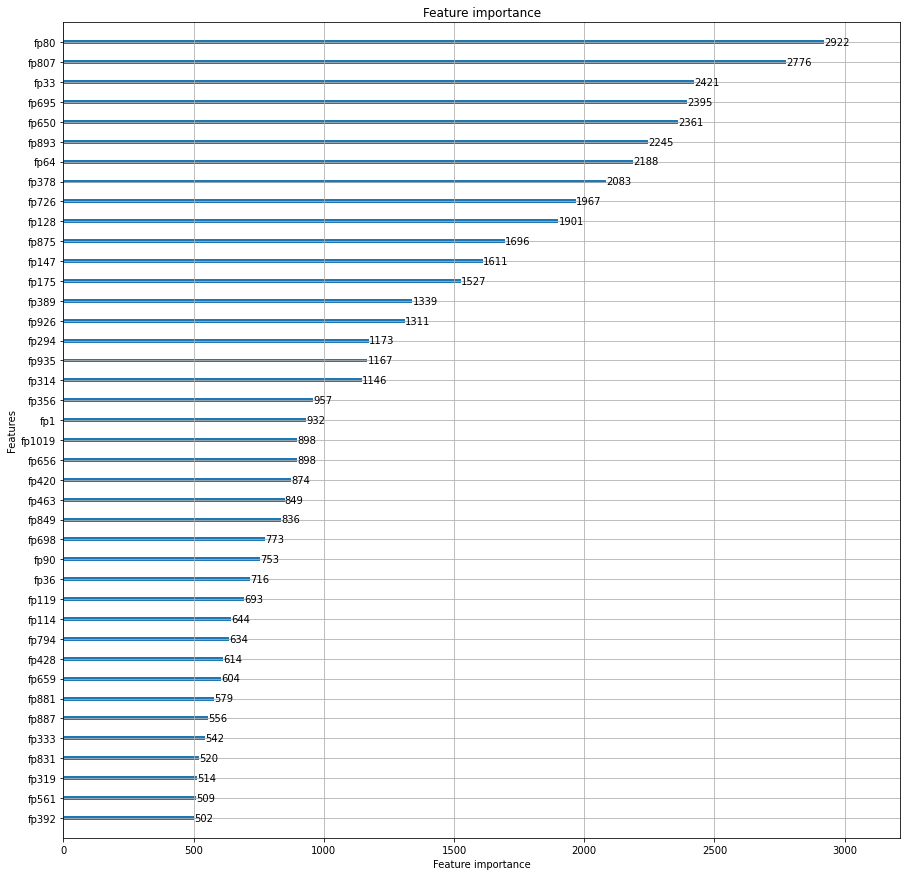

In [127]:
lgb.plot_importance(model, max_num_features=40, figsize=(15,15))

Suprise, the predicted logP by RDKit is by far the most important feature. At least this shows, that the setup so far is correct and in fact the ML model learns basically some corrections to this internal logP model.

Lets remove unimportant features, the threshold is somewhat arbitrary, but could of course be optimized further. 

In [128]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns),reverse=True), columns=['Value','Feature'])
feature_imp = feature_imp.loc[feature_imp.Value>10]
feature_imp.shape

(397, 2)

In [129]:
Xtrain = Xtrain[feature_imp.Feature]
Xval = Xval[feature_imp.Feature]

Now we do a cross-validation with the selected features. Note this is not perfectly clean, as it would have been more correct to carry out the feature selection without peaking at the experimental training data.  
For the cross-validation the RSME would be about 0.50 with the RDKit standard descriptors.

In [130]:
results = cross_val_score(model, Xtrain, ytrain, cv=cv, scoring='neg_mean_squared_error', )
print("\nResults: %.2f (%.2f) RMSE" % ((-1 * results.mean())**0.5, (results.std())**0.5))


Results: 0.87 (0.25) RMSE


## Parameter selection

OK - now lets improve the results a bit by optimisation of the LGBM parameters. We vary the learning rate, the sub sampling, i.e. how much of the data samples is left aside for each tree (*stochastic* gradient boosting), and the maximal depth of the regression trees. The number of estimators we set high enough in order to give the classifier the opportunity to do early stopping by monitoring the validation set.

We use basically a gridsearch on the parameter space and here also scikit learn offers the tools for doing this, via the `GridSearchCV` class. Of course we do this using cross-validation in order not to overfit.

Note the `refit` keyword we use, it allows us to return the best estimator after the grid search. 

In [131]:
parameters = {'n_estimators': [5000], 'learning_rate': [0.01,0.02,0.03],'subsample':[0.5], 'max_depth': [12]}
model = GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=cv, n_jobs = 4,refit=True, verbose=0)
model.fit(Xtrain, ytrain, early_stopping_rounds=100,eval_metric=['l1','l2'], eval_set=[(Xtrain, ytrain), (Xval, yval)])
df_res = pd.DataFrame(model.cv_results_)
df_res['rmse'] = (-1*df_res['mean_test_score'])**0.5
print(df_res[['rmse','params','rank_test_score']].sort_values('rank_test_score',ascending=True))

[1]	training's l1: 1.39166	training's l2: 3.25978	valid_1's l1: 1.39026	valid_1's l2: 3.33712
Training until validation scores don't improve for 100 rounds
[2]	training's l1: 1.37697	training's l2: 3.19208	valid_1's l1: 1.37562	valid_1's l2: 3.26597
[3]	training's l1: 1.36222	training's l2: 3.12427	valid_1's l1: 1.36108	valid_1's l2: 3.19591
[4]	training's l1: 1.34838	training's l2: 3.06271	valid_1's l1: 1.34764	valid_1's l2: 3.13273
[5]	training's l1: 1.33489	training's l2: 3.00211	valid_1's l1: 1.33455	valid_1's l2: 3.07015
[6]	training's l1: 1.32195	training's l2: 2.94475	valid_1's l1: 1.32206	valid_1's l2: 3.01123
[7]	training's l1: 1.30941	training's l2: 2.88857	valid_1's l1: 1.31038	valid_1's l2: 2.95546
[8]	training's l1: 1.29744	training's l2: 2.83692	valid_1's l1: 1.29905	valid_1's l2: 2.90279
[9]	training's l1: 1.28643	training's l2: 2.78943	valid_1's l1: 1.28859	valid_1's l2: 2.85341
[10]	training's l1: 1.27575	training's l2: 2.74354	valid_1's l1: 1.27858	valid_1's l2: 2.805

[91]	training's l1: 0.87329	training's l2: 1.36158	valid_1's l1: 0.898033	valid_1's l2: 1.42022
[92]	training's l1: 0.870968	training's l2: 1.3554	valid_1's l1: 0.895493	valid_1's l2: 1.41404
[93]	training's l1: 0.868866	training's l2: 1.34921	valid_1's l1: 0.893421	valid_1's l2: 1.40822
[94]	training's l1: 0.866844	training's l2: 1.34355	valid_1's l1: 0.891341	valid_1's l2: 1.40256
[95]	training's l1: 0.864829	training's l2: 1.33863	valid_1's l1: 0.889576	valid_1's l2: 1.39815
[96]	training's l1: 0.862532	training's l2: 1.33231	valid_1's l1: 0.8873	valid_1's l2: 1.39218
[97]	training's l1: 0.860673	training's l2: 1.32688	valid_1's l1: 0.885555	valid_1's l2: 1.387
[98]	training's l1: 0.858757	training's l2: 1.32197	valid_1's l1: 0.884216	valid_1's l2: 1.3828
[99]	training's l1: 0.856318	training's l2: 1.31485	valid_1's l1: 0.882029	valid_1's l2: 1.3759
[100]	training's l1: 0.854498	training's l2: 1.30966	valid_1's l1: 0.88037	valid_1's l2: 1.37192
[101]	training's l1: 0.852526	training

[179]	training's l1: 0.746852	training's l2: 1.03264	valid_1's l1: 0.785281	valid_1's l2: 1.12529
[180]	training's l1: 0.745835	training's l2: 1.02993	valid_1's l1: 0.784421	valid_1's l2: 1.12273
[181]	training's l1: 0.745075	training's l2: 1.02807	valid_1's l1: 0.783771	valid_1's l2: 1.12108
[182]	training's l1: 0.744342	training's l2: 1.02628	valid_1's l1: 0.783153	valid_1's l2: 1.11978
[183]	training's l1: 0.743523	training's l2: 1.02411	valid_1's l1: 0.78266	valid_1's l2: 1.11825
[184]	training's l1: 0.74262	training's l2: 1.02227	valid_1's l1: 0.782108	valid_1's l2: 1.11659
[185]	training's l1: 0.741608	training's l2: 1.02002	valid_1's l1: 0.781231	valid_1's l2: 1.11475
[186]	training's l1: 0.740901	training's l2: 1.01827	valid_1's l1: 0.780554	valid_1's l2: 1.11308
[187]	training's l1: 0.740005	training's l2: 1.01634	valid_1's l1: 0.779853	valid_1's l2: 1.11114
[188]	training's l1: 0.739251	training's l2: 1.01479	valid_1's l1: 0.779159	valid_1's l2: 1.1095
[189]	training's l1: 0.

[272]	training's l1: 0.682674	training's l2: 0.881945	valid_1's l1: 0.732934	valid_1's l2: 0.990611
[273]	training's l1: 0.682296	training's l2: 0.881135	valid_1's l1: 0.732492	valid_1's l2: 0.989971
[274]	training's l1: 0.681797	training's l2: 0.880199	valid_1's l1: 0.732059	valid_1's l2: 0.989092
[275]	training's l1: 0.681271	training's l2: 0.878939	valid_1's l1: 0.731626	valid_1's l2: 0.98805
[276]	training's l1: 0.680879	training's l2: 0.877986	valid_1's l1: 0.73138	valid_1's l2: 0.987509
[277]	training's l1: 0.680379	training's l2: 0.876759	valid_1's l1: 0.730876	valid_1's l2: 0.986294
[278]	training's l1: 0.67997	training's l2: 0.875777	valid_1's l1: 0.730521	valid_1's l2: 0.985373
[279]	training's l1: 0.679242	training's l2: 0.874044	valid_1's l1: 0.729749	valid_1's l2: 0.983684
[280]	training's l1: 0.678821	training's l2: 0.872883	valid_1's l1: 0.7293	valid_1's l2: 0.982383
[281]	training's l1: 0.6784	training's l2: 0.87192	valid_1's l1: 0.729007	valid_1's l2: 0.981605
[282]	tr

[367]	training's l1: 0.645061	training's l2: 0.794787	valid_1's l1: 0.705639	valid_1's l2: 0.921462
[368]	training's l1: 0.644664	training's l2: 0.793847	valid_1's l1: 0.705346	valid_1's l2: 0.920716
[369]	training's l1: 0.644256	training's l2: 0.793065	valid_1's l1: 0.705125	valid_1's l2: 0.920291
[370]	training's l1: 0.6439	training's l2: 0.79243	valid_1's l1: 0.704938	valid_1's l2: 0.920061
[371]	training's l1: 0.643573	training's l2: 0.791543	valid_1's l1: 0.704757	valid_1's l2: 0.919622
[372]	training's l1: 0.643073	training's l2: 0.790501	valid_1's l1: 0.704157	valid_1's l2: 0.918371
[373]	training's l1: 0.642763	training's l2: 0.789854	valid_1's l1: 0.704034	valid_1's l2: 0.918185
[374]	training's l1: 0.642508	training's l2: 0.789371	valid_1's l1: 0.703761	valid_1's l2: 0.917592
[375]	training's l1: 0.642223	training's l2: 0.788543	valid_1's l1: 0.703295	valid_1's l2: 0.91691
[376]	training's l1: 0.641858	training's l2: 0.787873	valid_1's l1: 0.703043	valid_1's l2: 0.916354
[377

[465]	training's l1: 0.618368	training's l2: 0.734711	valid_1's l1: 0.687208	valid_1's l2: 0.877065
[466]	training's l1: 0.618188	training's l2: 0.73436	valid_1's l1: 0.68715	valid_1's l2: 0.87682
[467]	training's l1: 0.618006	training's l2: 0.733955	valid_1's l1: 0.686981	valid_1's l2: 0.876493
[468]	training's l1: 0.617793	training's l2: 0.733528	valid_1's l1: 0.686971	valid_1's l2: 0.876611
[469]	training's l1: 0.617607	training's l2: 0.732975	valid_1's l1: 0.686745	valid_1's l2: 0.876034
[470]	training's l1: 0.617283	training's l2: 0.732275	valid_1's l1: 0.686627	valid_1's l2: 0.875458
[471]	training's l1: 0.616947	training's l2: 0.731451	valid_1's l1: 0.686366	valid_1's l2: 0.874788
[472]	training's l1: 0.616721	training's l2: 0.730961	valid_1's l1: 0.686197	valid_1's l2: 0.874419
[473]	training's l1: 0.616483	training's l2: 0.730358	valid_1's l1: 0.685765	valid_1's l2: 0.87361
[474]	training's l1: 0.616251	training's l2: 0.72982	valid_1's l1: 0.68566	valid_1's l2: 0.873338
[475]	

[557]	training's l1: 0.597726	training's l2: 0.688809	valid_1's l1: 0.67168	valid_1's l2: 0.841027
[558]	training's l1: 0.597605	training's l2: 0.6885	valid_1's l1: 0.671779	valid_1's l2: 0.841154
[559]	training's l1: 0.597393	training's l2: 0.688038	valid_1's l1: 0.671672	valid_1's l2: 0.841036
[560]	training's l1: 0.597219	training's l2: 0.687683	valid_1's l1: 0.671462	valid_1's l2: 0.840479
[561]	training's l1: 0.596884	training's l2: 0.687026	valid_1's l1: 0.671234	valid_1's l2: 0.839968
[562]	training's l1: 0.59679	training's l2: 0.686778	valid_1's l1: 0.671076	valid_1's l2: 0.839856
[563]	training's l1: 0.596664	training's l2: 0.686425	valid_1's l1: 0.670885	valid_1's l2: 0.839517
[564]	training's l1: 0.596539	training's l2: 0.686135	valid_1's l1: 0.67089	valid_1's l2: 0.839393
[565]	training's l1: 0.596394	training's l2: 0.685718	valid_1's l1: 0.67082	valid_1's l2: 0.839026
[566]	training's l1: 0.596221	training's l2: 0.685085	valid_1's l1: 0.670679	valid_1's l2: 0.838498
[567]	

[647]	training's l1: 0.581973	training's l2: 0.654155	valid_1's l1: 0.660992	valid_1's l2: 0.815642
[648]	training's l1: 0.581808	training's l2: 0.653781	valid_1's l1: 0.660734	valid_1's l2: 0.815114
[649]	training's l1: 0.581653	training's l2: 0.653439	valid_1's l1: 0.660654	valid_1's l2: 0.814873
[650]	training's l1: 0.581534	training's l2: 0.653144	valid_1's l1: 0.660521	valid_1's l2: 0.814849
[651]	training's l1: 0.581336	training's l2: 0.652788	valid_1's l1: 0.660415	valid_1's l2: 0.814715
[652]	training's l1: 0.580952	training's l2: 0.651999	valid_1's l1: 0.6601	valid_1's l2: 0.813678
[653]	training's l1: 0.580806	training's l2: 0.651703	valid_1's l1: 0.660002	valid_1's l2: 0.813673
[654]	training's l1: 0.58061	training's l2: 0.651359	valid_1's l1: 0.659909	valid_1's l2: 0.813447
[655]	training's l1: 0.580302	training's l2: 0.65091	valid_1's l1: 0.659652	valid_1's l2: 0.813112
[656]	training's l1: 0.580064	training's l2: 0.650345	valid_1's l1: 0.659444	valid_1's l2: 0.812685
[657

[737]	training's l1: 0.568036	training's l2: 0.624944	valid_1's l1: 0.651139	valid_1's l2: 0.794592
[738]	training's l1: 0.567954	training's l2: 0.624702	valid_1's l1: 0.651209	valid_1's l2: 0.7946
[739]	training's l1: 0.567759	training's l2: 0.624354	valid_1's l1: 0.651045	valid_1's l2: 0.794383
[740]	training's l1: 0.567669	training's l2: 0.624025	valid_1's l1: 0.651087	valid_1's l2: 0.794363
[741]	training's l1: 0.567534	training's l2: 0.623796	valid_1's l1: 0.650991	valid_1's l2: 0.79431
[742]	training's l1: 0.567354	training's l2: 0.623548	valid_1's l1: 0.650862	valid_1's l2: 0.794105
[743]	training's l1: 0.567229	training's l2: 0.623237	valid_1's l1: 0.650775	valid_1's l2: 0.794021
[744]	training's l1: 0.567167	training's l2: 0.623015	valid_1's l1: 0.650691	valid_1's l2: 0.793777
[745]	training's l1: 0.566988	training's l2: 0.622724	valid_1's l1: 0.650685	valid_1's l2: 0.793813
[746]	training's l1: 0.566841	training's l2: 0.622398	valid_1's l1: 0.650473	valid_1's l2: 0.79347
[747

[827]	training's l1: 0.556826	training's l2: 0.601179	valid_1's l1: 0.644098	valid_1's l2: 0.779753
[828]	training's l1: 0.556706	training's l2: 0.600943	valid_1's l1: 0.643889	valid_1's l2: 0.779511
[829]	training's l1: 0.556553	training's l2: 0.600626	valid_1's l1: 0.643819	valid_1's l2: 0.779294
[830]	training's l1: 0.556468	training's l2: 0.600387	valid_1's l1: 0.643753	valid_1's l2: 0.779159
[831]	training's l1: 0.556278	training's l2: 0.599966	valid_1's l1: 0.643527	valid_1's l2: 0.778834
[832]	training's l1: 0.556184	training's l2: 0.599702	valid_1's l1: 0.643417	valid_1's l2: 0.77861
[833]	training's l1: 0.556059	training's l2: 0.59945	valid_1's l1: 0.643415	valid_1's l2: 0.778654
[834]	training's l1: 0.555999	training's l2: 0.599267	valid_1's l1: 0.643379	valid_1's l2: 0.778534
[835]	training's l1: 0.555878	training's l2: 0.599003	valid_1's l1: 0.643315	valid_1's l2: 0.778533
[836]	training's l1: 0.555789	training's l2: 0.598789	valid_1's l1: 0.643272	valid_1's l2: 0.778433
[8

[918]	training's l1: 0.546316	training's l2: 0.579512	valid_1's l1: 0.638283	valid_1's l2: 0.768259
[919]	training's l1: 0.546204	training's l2: 0.579251	valid_1's l1: 0.638218	valid_1's l2: 0.768218
[920]	training's l1: 0.546056	training's l2: 0.57905	valid_1's l1: 0.638116	valid_1's l2: 0.768178
[921]	training's l1: 0.546004	training's l2: 0.578893	valid_1's l1: 0.638012	valid_1's l2: 0.767889
[922]	training's l1: 0.545937	training's l2: 0.578791	valid_1's l1: 0.637974	valid_1's l2: 0.767665
[923]	training's l1: 0.545791	training's l2: 0.578451	valid_1's l1: 0.637917	valid_1's l2: 0.767603
[924]	training's l1: 0.54568	training's l2: 0.578221	valid_1's l1: 0.637839	valid_1's l2: 0.76747
[925]	training's l1: 0.545557	training's l2: 0.577981	valid_1's l1: 0.637749	valid_1's l2: 0.767282
[926]	training's l1: 0.545491	training's l2: 0.577846	valid_1's l1: 0.637707	valid_1's l2: 0.767102
[927]	training's l1: 0.545452	training's l2: 0.577715	valid_1's l1: 0.637669	valid_1's l2: 0.766916
[92

[1007]	training's l1: 0.536724	training's l2: 0.559579	valid_1's l1: 0.631917	valid_1's l2: 0.754328
[1008]	training's l1: 0.536649	training's l2: 0.55939	valid_1's l1: 0.631723	valid_1's l2: 0.753956
[1009]	training's l1: 0.536603	training's l2: 0.559314	valid_1's l1: 0.631723	valid_1's l2: 0.753915
[1010]	training's l1: 0.536513	training's l2: 0.559072	valid_1's l1: 0.631645	valid_1's l2: 0.753708
[1011]	training's l1: 0.53646	training's l2: 0.558969	valid_1's l1: 0.631538	valid_1's l2: 0.753582
[1012]	training's l1: 0.536384	training's l2: 0.558819	valid_1's l1: 0.631456	valid_1's l2: 0.753416
[1013]	training's l1: 0.536314	training's l2: 0.558644	valid_1's l1: 0.631455	valid_1's l2: 0.753371
[1014]	training's l1: 0.536204	training's l2: 0.558524	valid_1's l1: 0.631437	valid_1's l2: 0.753429
[1015]	training's l1: 0.536081	training's l2: 0.558342	valid_1's l1: 0.631317	valid_1's l2: 0.753199
[1016]	training's l1: 0.536	training's l2: 0.558229	valid_1's l1: 0.631263	valid_1's l2: 0.75

[1104]	training's l1: 0.528035	training's l2: 0.542463	valid_1's l1: 0.627264	valid_1's l2: 0.744367
[1105]	training's l1: 0.527876	training's l2: 0.542181	valid_1's l1: 0.627314	valid_1's l2: 0.744194
[1106]	training's l1: 0.527806	training's l2: 0.542013	valid_1's l1: 0.627259	valid_1's l2: 0.74402
[1107]	training's l1: 0.527756	training's l2: 0.541814	valid_1's l1: 0.627307	valid_1's l2: 0.743865
[1108]	training's l1: 0.527704	training's l2: 0.54171	valid_1's l1: 0.627314	valid_1's l2: 0.743897
[1109]	training's l1: 0.527653	training's l2: 0.541608	valid_1's l1: 0.627297	valid_1's l2: 0.743796
[1110]	training's l1: 0.527575	training's l2: 0.541445	valid_1's l1: 0.627027	valid_1's l2: 0.743318
[1111]	training's l1: 0.527498	training's l2: 0.541259	valid_1's l1: 0.62703	valid_1's l2: 0.743129
[1112]	training's l1: 0.527416	training's l2: 0.5411	valid_1's l1: 0.627051	valid_1's l2: 0.743061
[1113]	training's l1: 0.52736	training's l2: 0.540985	valid_1's l1: 0.626934	valid_1's l2: 0.742

[1197]	training's l1: 0.519682	training's l2: 0.526353	valid_1's l1: 0.623234	valid_1's l2: 0.735605
[1198]	training's l1: 0.519587	training's l2: 0.526189	valid_1's l1: 0.623323	valid_1's l2: 0.735802
[1199]	training's l1: 0.519518	training's l2: 0.526061	valid_1's l1: 0.623323	valid_1's l2: 0.735837
[1200]	training's l1: 0.519412	training's l2: 0.525929	valid_1's l1: 0.623246	valid_1's l2: 0.735713
[1201]	training's l1: 0.519341	training's l2: 0.52583	valid_1's l1: 0.623185	valid_1's l2: 0.735571
[1202]	training's l1: 0.5192	training's l2: 0.525616	valid_1's l1: 0.623148	valid_1's l2: 0.73541
[1203]	training's l1: 0.51913	training's l2: 0.525512	valid_1's l1: 0.623065	valid_1's l2: 0.73526
[1204]	training's l1: 0.519058	training's l2: 0.525365	valid_1's l1: 0.623014	valid_1's l2: 0.735065
[1205]	training's l1: 0.518962	training's l2: 0.525233	valid_1's l1: 0.622866	valid_1's l2: 0.734881
[1206]	training's l1: 0.518872	training's l2: 0.525	valid_1's l1: 0.622814	valid_1's l2: 0.734797

[1287]	training's l1: 0.512853	training's l2: 0.51299	valid_1's l1: 0.619596	valid_1's l2: 0.727833
[1288]	training's l1: 0.512808	training's l2: 0.512865	valid_1's l1: 0.619644	valid_1's l2: 0.727889
[1289]	training's l1: 0.512729	training's l2: 0.512739	valid_1's l1: 0.619572	valid_1's l2: 0.727793
[1290]	training's l1: 0.512696	training's l2: 0.512663	valid_1's l1: 0.61955	valid_1's l2: 0.727778
[1291]	training's l1: 0.512553	training's l2: 0.512409	valid_1's l1: 0.619577	valid_1's l2: 0.727813
[1292]	training's l1: 0.512513	training's l2: 0.512296	valid_1's l1: 0.619541	valid_1's l2: 0.727717
[1293]	training's l1: 0.5125	training's l2: 0.512242	valid_1's l1: 0.61949	valid_1's l2: 0.727624
[1294]	training's l1: 0.512409	training's l2: 0.512099	valid_1's l1: 0.619452	valid_1's l2: 0.72758
[1295]	training's l1: 0.512259	training's l2: 0.511885	valid_1's l1: 0.619386	valid_1's l2: 0.727451
[1296]	training's l1: 0.512197	training's l2: 0.5117	valid_1's l1: 0.619225	valid_1's l2: 0.72729

[1371]	training's l1: 0.505866	training's l2: 0.500122	valid_1's l1: 0.614952	valid_1's l2: 0.719521
[1372]	training's l1: 0.505782	training's l2: 0.499943	valid_1's l1: 0.614941	valid_1's l2: 0.719521
[1373]	training's l1: 0.505687	training's l2: 0.499639	valid_1's l1: 0.614951	valid_1's l2: 0.719406
[1374]	training's l1: 0.505585	training's l2: 0.499415	valid_1's l1: 0.614806	valid_1's l2: 0.719056
[1375]	training's l1: 0.505555	training's l2: 0.499312	valid_1's l1: 0.61484	valid_1's l2: 0.719075
[1376]	training's l1: 0.505485	training's l2: 0.499182	valid_1's l1: 0.614952	valid_1's l2: 0.719137
[1377]	training's l1: 0.505398	training's l2: 0.499085	valid_1's l1: 0.614961	valid_1's l2: 0.719194
[1378]	training's l1: 0.505306	training's l2: 0.498925	valid_1's l1: 0.61499	valid_1's l2: 0.719185
[1379]	training's l1: 0.505228	training's l2: 0.498777	valid_1's l1: 0.614946	valid_1's l2: 0.718993
[1380]	training's l1: 0.505195	training's l2: 0.498674	valid_1's l1: 0.614853	valid_1's l2: 0

[1469]	training's l1: 0.49904	training's l2: 0.48708	valid_1's l1: 0.612138	valid_1's l2: 0.712526
[1470]	training's l1: 0.498972	training's l2: 0.48695	valid_1's l1: 0.612003	valid_1's l2: 0.712322
[1471]	training's l1: 0.498867	training's l2: 0.486805	valid_1's l1: 0.611963	valid_1's l2: 0.712143
[1472]	training's l1: 0.498769	training's l2: 0.486601	valid_1's l1: 0.611968	valid_1's l2: 0.712108
[1473]	training's l1: 0.4987	training's l2: 0.486486	valid_1's l1: 0.611797	valid_1's l2: 0.711888
[1474]	training's l1: 0.498629	training's l2: 0.486353	valid_1's l1: 0.611854	valid_1's l2: 0.711899
[1475]	training's l1: 0.498493	training's l2: 0.486207	valid_1's l1: 0.611744	valid_1's l2: 0.711747
[1476]	training's l1: 0.498411	training's l2: 0.486043	valid_1's l1: 0.611805	valid_1's l2: 0.711705
[1477]	training's l1: 0.498358	training's l2: 0.485909	valid_1's l1: 0.611794	valid_1's l2: 0.711649
[1478]	training's l1: 0.498288	training's l2: 0.48582	valid_1's l1: 0.611769	valid_1's l2: 0.711

[1551]	training's l1: 0.492787	training's l2: 0.475875	valid_1's l1: 0.609214	valid_1's l2: 0.706051
[1552]	training's l1: 0.492739	training's l2: 0.475782	valid_1's l1: 0.609175	valid_1's l2: 0.706067
[1553]	training's l1: 0.492617	training's l2: 0.475649	valid_1's l1: 0.60912	valid_1's l2: 0.705991
[1554]	training's l1: 0.492543	training's l2: 0.475511	valid_1's l1: 0.609023	valid_1's l2: 0.7058
[1555]	training's l1: 0.492472	training's l2: 0.475366	valid_1's l1: 0.609167	valid_1's l2: 0.706171
[1556]	training's l1: 0.492422	training's l2: 0.475268	valid_1's l1: 0.609094	valid_1's l2: 0.706093
[1557]	training's l1: 0.492313	training's l2: 0.475081	valid_1's l1: 0.609155	valid_1's l2: 0.706111
[1558]	training's l1: 0.492266	training's l2: 0.474941	valid_1's l1: 0.609052	valid_1's l2: 0.70585
[1559]	training's l1: 0.492215	training's l2: 0.47486	valid_1's l1: 0.609055	valid_1's l2: 0.7059
[1560]	training's l1: 0.49219	training's l2: 0.474743	valid_1's l1: 0.609007	valid_1's l2: 0.70579

[1638]	training's l1: 0.487402	training's l2: 0.466082	valid_1's l1: 0.6063	valid_1's l2: 0.699547
[1639]	training's l1: 0.487314	training's l2: 0.465978	valid_1's l1: 0.606259	valid_1's l2: 0.699453
[1640]	training's l1: 0.487271	training's l2: 0.465814	valid_1's l1: 0.606135	valid_1's l2: 0.699242
[1641]	training's l1: 0.487157	training's l2: 0.465613	valid_1's l1: 0.606117	valid_1's l2: 0.699316
[1642]	training's l1: 0.487118	training's l2: 0.465506	valid_1's l1: 0.606093	valid_1's l2: 0.69915
[1643]	training's l1: 0.487055	training's l2: 0.465407	valid_1's l1: 0.606021	valid_1's l2: 0.699136
[1644]	training's l1: 0.487038	training's l2: 0.465343	valid_1's l1: 0.606033	valid_1's l2: 0.699211
[1645]	training's l1: 0.486967	training's l2: 0.465164	valid_1's l1: 0.606	valid_1's l2: 0.699102
[1646]	training's l1: 0.486881	training's l2: 0.465028	valid_1's l1: 0.606031	valid_1's l2: 0.699071
[1647]	training's l1: 0.486823	training's l2: 0.464931	valid_1's l1: 0.605972	valid_1's l2: 0.698

[1721]	training's l1: 0.482098	training's l2: 0.456468	valid_1's l1: 0.603482	valid_1's l2: 0.694306
[1722]	training's l1: 0.482061	training's l2: 0.45634	valid_1's l1: 0.603486	valid_1's l2: 0.694344
[1723]	training's l1: 0.482014	training's l2: 0.456241	valid_1's l1: 0.603478	valid_1's l2: 0.694367
[1724]	training's l1: 0.481965	training's l2: 0.45613	valid_1's l1: 0.603467	valid_1's l2: 0.69432
[1725]	training's l1: 0.481816	training's l2: 0.455925	valid_1's l1: 0.60334	valid_1's l2: 0.69431
[1726]	training's l1: 0.481743	training's l2: 0.455796	valid_1's l1: 0.60319	valid_1's l2: 0.69415
[1727]	training's l1: 0.48171	training's l2: 0.455718	valid_1's l1: 0.603168	valid_1's l2: 0.694046
[1728]	training's l1: 0.481688	training's l2: 0.455631	valid_1's l1: 0.603177	valid_1's l2: 0.69402
[1729]	training's l1: 0.481612	training's l2: 0.455546	valid_1's l1: 0.603145	valid_1's l2: 0.69404
[1730]	training's l1: 0.481578	training's l2: 0.455465	valid_1's l1: 0.603131	valid_1's l2: 0.693843


[1810]	training's l1: 0.476976	training's l2: 0.447189	valid_1's l1: 0.601149	valid_1's l2: 0.688901
[1811]	training's l1: 0.476939	training's l2: 0.447126	valid_1's l1: 0.601114	valid_1's l2: 0.688906
[1812]	training's l1: 0.476911	training's l2: 0.447056	valid_1's l1: 0.601165	valid_1's l2: 0.689082
[1813]	training's l1: 0.476862	training's l2: 0.446991	valid_1's l1: 0.601192	valid_1's l2: 0.689181
[1814]	training's l1: 0.47676	training's l2: 0.446876	valid_1's l1: 0.601022	valid_1's l2: 0.689003
[1815]	training's l1: 0.476643	training's l2: 0.44675	valid_1's l1: 0.601023	valid_1's l2: 0.688867
[1816]	training's l1: 0.47659	training's l2: 0.446667	valid_1's l1: 0.601038	valid_1's l2: 0.688816
[1817]	training's l1: 0.476513	training's l2: 0.446527	valid_1's l1: 0.601022	valid_1's l2: 0.688751
[1818]	training's l1: 0.476439	training's l2: 0.446396	valid_1's l1: 0.601045	valid_1's l2: 0.688816
[1819]	training's l1: 0.476337	training's l2: 0.446261	valid_1's l1: 0.600983	valid_1's l2: 0.

[1904]	training's l1: 0.471343	training's l2: 0.437648	valid_1's l1: 0.599242	valid_1's l2: 0.685547
[1905]	training's l1: 0.471302	training's l2: 0.437578	valid_1's l1: 0.599189	valid_1's l2: 0.685639
[1906]	training's l1: 0.47121	training's l2: 0.437493	valid_1's l1: 0.599072	valid_1's l2: 0.685503
[1907]	training's l1: 0.471161	training's l2: 0.437381	valid_1's l1: 0.599024	valid_1's l2: 0.685399
[1908]	training's l1: 0.471118	training's l2: 0.437312	valid_1's l1: 0.599083	valid_1's l2: 0.685446
[1909]	training's l1: 0.47106	training's l2: 0.437245	valid_1's l1: 0.599044	valid_1's l2: 0.685366
[1910]	training's l1: 0.47096	training's l2: 0.437132	valid_1's l1: 0.598928	valid_1's l2: 0.685128
[1911]	training's l1: 0.470919	training's l2: 0.437033	valid_1's l1: 0.598899	valid_1's l2: 0.68512
[1912]	training's l1: 0.470862	training's l2: 0.436927	valid_1's l1: 0.598792	valid_1's l2: 0.684939
[1913]	training's l1: 0.470772	training's l2: 0.436818	valid_1's l1: 0.598824	valid_1's l2: 0.6

[1997]	training's l1: 0.466288	training's l2: 0.428714	valid_1's l1: 0.596154	valid_1's l2: 0.679892
[1998]	training's l1: 0.466235	training's l2: 0.428625	valid_1's l1: 0.59615	valid_1's l2: 0.679827
[1999]	training's l1: 0.466196	training's l2: 0.428501	valid_1's l1: 0.596186	valid_1's l2: 0.67975
[2000]	training's l1: 0.466177	training's l2: 0.428431	valid_1's l1: 0.596234	valid_1's l2: 0.679898
[2001]	training's l1: 0.466129	training's l2: 0.428342	valid_1's l1: 0.596214	valid_1's l2: 0.679901
[2002]	training's l1: 0.466076	training's l2: 0.428199	valid_1's l1: 0.596154	valid_1's l2: 0.679745
[2003]	training's l1: 0.466038	training's l2: 0.428143	valid_1's l1: 0.596256	valid_1's l2: 0.679819
[2004]	training's l1: 0.466018	training's l2: 0.428079	valid_1's l1: 0.596232	valid_1's l2: 0.679859
[2005]	training's l1: 0.465917	training's l2: 0.428012	valid_1's l1: 0.596148	valid_1's l2: 0.679648
[2006]	training's l1: 0.465864	training's l2: 0.427853	valid_1's l1: 0.596191	valid_1's l2: 0

[2092]	training's l1: 0.461417	training's l2: 0.419559	valid_1's l1: 0.593559	valid_1's l2: 0.675072
[2093]	training's l1: 0.461342	training's l2: 0.419446	valid_1's l1: 0.593526	valid_1's l2: 0.674997
[2094]	training's l1: 0.461322	training's l2: 0.419382	valid_1's l1: 0.593501	valid_1's l2: 0.674837
[2095]	training's l1: 0.461268	training's l2: 0.419262	valid_1's l1: 0.593537	valid_1's l2: 0.674784
[2096]	training's l1: 0.461252	training's l2: 0.419173	valid_1's l1: 0.593516	valid_1's l2: 0.674619
[2097]	training's l1: 0.461197	training's l2: 0.419059	valid_1's l1: 0.593452	valid_1's l2: 0.674542
[2098]	training's l1: 0.461066	training's l2: 0.418932	valid_1's l1: 0.593498	valid_1's l2: 0.674665
[2099]	training's l1: 0.461004	training's l2: 0.418852	valid_1's l1: 0.593537	valid_1's l2: 0.674668
[2100]	training's l1: 0.460938	training's l2: 0.418758	valid_1's l1: 0.593438	valid_1's l2: 0.674551
[2101]	training's l1: 0.460884	training's l2: 0.418722	valid_1's l1: 0.593408	valid_1's l2:

[2181]	training's l1: 0.456576	training's l2: 0.411754	valid_1's l1: 0.591538	valid_1's l2: 0.671668
[2182]	training's l1: 0.456565	training's l2: 0.411687	valid_1's l1: 0.591699	valid_1's l2: 0.671795
[2183]	training's l1: 0.45654	training's l2: 0.411621	valid_1's l1: 0.591658	valid_1's l2: 0.67168
[2184]	training's l1: 0.456494	training's l2: 0.411532	valid_1's l1: 0.591663	valid_1's l2: 0.671649
[2185]	training's l1: 0.456481	training's l2: 0.411483	valid_1's l1: 0.591717	valid_1's l2: 0.671707
[2186]	training's l1: 0.456471	training's l2: 0.411426	valid_1's l1: 0.591716	valid_1's l2: 0.671635
[2187]	training's l1: 0.456412	training's l2: 0.41132	valid_1's l1: 0.591713	valid_1's l2: 0.671626
[2188]	training's l1: 0.456374	training's l2: 0.411256	valid_1's l1: 0.591652	valid_1's l2: 0.671627
[2189]	training's l1: 0.45635	training's l2: 0.411201	valid_1's l1: 0.591612	valid_1's l2: 0.671568
[2190]	training's l1: 0.456309	training's l2: 0.411148	valid_1's l1: 0.591681	valid_1's l2: 0.6

[2266]	training's l1: 0.452473	training's l2: 0.404664	valid_1's l1: 0.589237	valid_1's l2: 0.666572
[2267]	training's l1: 0.452457	training's l2: 0.404617	valid_1's l1: 0.589241	valid_1's l2: 0.666522
[2268]	training's l1: 0.452406	training's l2: 0.404485	valid_1's l1: 0.589265	valid_1's l2: 0.666569
[2269]	training's l1: 0.45232	training's l2: 0.404386	valid_1's l1: 0.589322	valid_1's l2: 0.666576
[2270]	training's l1: 0.452296	training's l2: 0.404337	valid_1's l1: 0.589264	valid_1's l2: 0.66654
[2271]	training's l1: 0.452212	training's l2: 0.404247	valid_1's l1: 0.589257	valid_1's l2: 0.666544
[2272]	training's l1: 0.452145	training's l2: 0.404163	valid_1's l1: 0.58923	valid_1's l2: 0.666468
[2273]	training's l1: 0.452073	training's l2: 0.404057	valid_1's l1: 0.58919	valid_1's l2: 0.666434
[2274]	training's l1: 0.452066	training's l2: 0.404013	valid_1's l1: 0.589108	valid_1's l2: 0.666313
[2275]	training's l1: 0.452066	training's l2: 0.403914	valid_1's l1: 0.589032	valid_1's l2: 0.6

[2348]	training's l1: 0.448751	training's l2: 0.398115	valid_1's l1: 0.588118	valid_1's l2: 0.663221
[2349]	training's l1: 0.448672	training's l2: 0.398028	valid_1's l1: 0.588034	valid_1's l2: 0.663103
[2350]	training's l1: 0.44869	training's l2: 0.397961	valid_1's l1: 0.587964	valid_1's l2: 0.662976
[2351]	training's l1: 0.448644	training's l2: 0.397905	valid_1's l1: 0.587876	valid_1's l2: 0.662855
[2352]	training's l1: 0.448582	training's l2: 0.397832	valid_1's l1: 0.58783	valid_1's l2: 0.662782
[2353]	training's l1: 0.448539	training's l2: 0.397779	valid_1's l1: 0.587765	valid_1's l2: 0.662711
[2354]	training's l1: 0.448511	training's l2: 0.397739	valid_1's l1: 0.587779	valid_1's l2: 0.662733
[2355]	training's l1: 0.448515	training's l2: 0.397711	valid_1's l1: 0.587767	valid_1's l2: 0.662614
[2356]	training's l1: 0.448499	training's l2: 0.397593	valid_1's l1: 0.587739	valid_1's l2: 0.662488
[2357]	training's l1: 0.448458	training's l2: 0.397534	valid_1's l1: 0.587784	valid_1's l2: 0

[2442]	training's l1: 0.44431	training's l2: 0.391027	valid_1's l1: 0.585514	valid_1's l2: 0.658819
[2443]	training's l1: 0.444249	training's l2: 0.39095	valid_1's l1: 0.585463	valid_1's l2: 0.658663
[2444]	training's l1: 0.444224	training's l2: 0.3909	valid_1's l1: 0.585409	valid_1's l2: 0.658657
[2445]	training's l1: 0.444164	training's l2: 0.390858	valid_1's l1: 0.585356	valid_1's l2: 0.658608
[2446]	training's l1: 0.444109	training's l2: 0.39078	valid_1's l1: 0.585352	valid_1's l2: 0.658562
[2447]	training's l1: 0.444104	training's l2: 0.390719	valid_1's l1: 0.585418	valid_1's l2: 0.658698
[2448]	training's l1: 0.444067	training's l2: 0.390668	valid_1's l1: 0.585342	valid_1's l2: 0.658595
[2449]	training's l1: 0.443992	training's l2: 0.390597	valid_1's l1: 0.585271	valid_1's l2: 0.658463
[2450]	training's l1: 0.443951	training's l2: 0.390534	valid_1's l1: 0.585223	valid_1's l2: 0.658361
[2451]	training's l1: 0.44396	training's l2: 0.39047	valid_1's l1: 0.585231	valid_1's l2: 0.6583

[2532]	training's l1: 0.440219	training's l2: 0.384436	valid_1's l1: 0.584123	valid_1's l2: 0.655894
[2533]	training's l1: 0.440151	training's l2: 0.384288	valid_1's l1: 0.584086	valid_1's l2: 0.655835
[2534]	training's l1: 0.440091	training's l2: 0.384191	valid_1's l1: 0.584036	valid_1's l2: 0.655936
[2535]	training's l1: 0.440038	training's l2: 0.384072	valid_1's l1: 0.584096	valid_1's l2: 0.655991
[2536]	training's l1: 0.440024	training's l2: 0.383994	valid_1's l1: 0.584075	valid_1's l2: 0.655953
[2537]	training's l1: 0.439946	training's l2: 0.383887	valid_1's l1: 0.584029	valid_1's l2: 0.656001
[2538]	training's l1: 0.439879	training's l2: 0.38378	valid_1's l1: 0.584173	valid_1's l2: 0.656109
[2539]	training's l1: 0.439795	training's l2: 0.383696	valid_1's l1: 0.584107	valid_1's l2: 0.655976
[2540]	training's l1: 0.439769	training's l2: 0.383626	valid_1's l1: 0.584091	valid_1's l2: 0.655974
[2541]	training's l1: 0.439733	training's l2: 0.383543	valid_1's l1: 0.584088	valid_1's l2: 

[2622]	training's l1: 0.43594	training's l2: 0.37801	valid_1's l1: 0.582619	valid_1's l2: 0.652417
[2623]	training's l1: 0.435919	training's l2: 0.377961	valid_1's l1: 0.582584	valid_1's l2: 0.652273
[2624]	training's l1: 0.435921	training's l2: 0.377916	valid_1's l1: 0.58265	valid_1's l2: 0.652283
[2625]	training's l1: 0.435901	training's l2: 0.377833	valid_1's l1: 0.582654	valid_1's l2: 0.652324
[2626]	training's l1: 0.435817	training's l2: 0.377751	valid_1's l1: 0.58258	valid_1's l2: 0.652278
[2627]	training's l1: 0.435754	training's l2: 0.377639	valid_1's l1: 0.582605	valid_1's l2: 0.652207
[2628]	training's l1: 0.435722	training's l2: 0.377573	valid_1's l1: 0.582539	valid_1's l2: 0.65209
[2629]	training's l1: 0.435679	training's l2: 0.377479	valid_1's l1: 0.582554	valid_1's l2: 0.652109
[2630]	training's l1: 0.435639	training's l2: 0.377437	valid_1's l1: 0.582473	valid_1's l2: 0.651926
[2631]	training's l1: 0.435599	training's l2: 0.377395	valid_1's l1: 0.582388	valid_1's l2: 0.65

[2710]	training's l1: 0.432432	training's l2: 0.371914	valid_1's l1: 0.58117	valid_1's l2: 0.649843
[2711]	training's l1: 0.432366	training's l2: 0.371843	valid_1's l1: 0.581112	valid_1's l2: 0.649803
[2712]	training's l1: 0.432329	training's l2: 0.371755	valid_1's l1: 0.58115	valid_1's l2: 0.64969
[2713]	training's l1: 0.432288	training's l2: 0.371698	valid_1's l1: 0.581173	valid_1's l2: 0.649755
[2714]	training's l1: 0.432241	training's l2: 0.371625	valid_1's l1: 0.581109	valid_1's l2: 0.649696
[2715]	training's l1: 0.432171	training's l2: 0.371562	valid_1's l1: 0.581	valid_1's l2: 0.649577
[2716]	training's l1: 0.432145	training's l2: 0.371497	valid_1's l1: 0.580988	valid_1's l2: 0.649526
[2717]	training's l1: 0.432116	training's l2: 0.371426	valid_1's l1: 0.581014	valid_1's l2: 0.649559
[2718]	training's l1: 0.432092	training's l2: 0.371379	valid_1's l1: 0.581061	valid_1's l2: 0.649543
[2719]	training's l1: 0.432094	training's l2: 0.371303	valid_1's l1: 0.581099	valid_1's l2: 0.649

[2806]	training's l1: 0.428458	training's l2: 0.365415	valid_1's l1: 0.579299	valid_1's l2: 0.645885
[2807]	training's l1: 0.428427	training's l2: 0.365358	valid_1's l1: 0.579233	valid_1's l2: 0.645732
[2808]	training's l1: 0.428372	training's l2: 0.365254	valid_1's l1: 0.579275	valid_1's l2: 0.645786
[2809]	training's l1: 0.428332	training's l2: 0.365214	valid_1's l1: 0.579254	valid_1's l2: 0.645772
[2810]	training's l1: 0.428275	training's l2: 0.36515	valid_1's l1: 0.579196	valid_1's l2: 0.645679
[2811]	training's l1: 0.428234	training's l2: 0.365064	valid_1's l1: 0.579156	valid_1's l2: 0.645608
[2812]	training's l1: 0.42819	training's l2: 0.364996	valid_1's l1: 0.57915	valid_1's l2: 0.645483
[2813]	training's l1: 0.428175	training's l2: 0.364956	valid_1's l1: 0.579142	valid_1's l2: 0.645463
[2814]	training's l1: 0.428154	training's l2: 0.36488	valid_1's l1: 0.57919	valid_1's l2: 0.645604
[2815]	training's l1: 0.428091	training's l2: 0.364826	valid_1's l1: 0.579171	valid_1's l2: 0.64

[2905]	training's l1: 0.424269	training's l2: 0.359053	valid_1's l1: 0.577805	valid_1's l2: 0.643919
[2906]	training's l1: 0.424208	training's l2: 0.358997	valid_1's l1: 0.577678	valid_1's l2: 0.643736
[2907]	training's l1: 0.424139	training's l2: 0.358938	valid_1's l1: 0.577638	valid_1's l2: 0.643772
[2908]	training's l1: 0.424074	training's l2: 0.358884	valid_1's l1: 0.577611	valid_1's l2: 0.643737
[2909]	training's l1: 0.424028	training's l2: 0.3588	valid_1's l1: 0.577531	valid_1's l2: 0.643585
[2910]	training's l1: 0.423977	training's l2: 0.358755	valid_1's l1: 0.577558	valid_1's l2: 0.643561
[2911]	training's l1: 0.42395	training's l2: 0.358706	valid_1's l1: 0.577547	valid_1's l2: 0.643529
[2912]	training's l1: 0.423907	training's l2: 0.35865	valid_1's l1: 0.577544	valid_1's l2: 0.643548
[2913]	training's l1: 0.423898	training's l2: 0.3586	valid_1's l1: 0.577562	valid_1's l2: 0.643614
[2914]	training's l1: 0.423843	training's l2: 0.358525	valid_1's l1: 0.577568	valid_1's l2: 0.643

[3005]	training's l1: 0.420353	training's l2: 0.353238	valid_1's l1: 0.576064	valid_1's l2: 0.64036
[3006]	training's l1: 0.42031	training's l2: 0.353147	valid_1's l1: 0.576111	valid_1's l2: 0.640342
[3007]	training's l1: 0.42027	training's l2: 0.353104	valid_1's l1: 0.576045	valid_1's l2: 0.640309
[3008]	training's l1: 0.420195	training's l2: 0.353039	valid_1's l1: 0.575977	valid_1's l2: 0.640175
[3009]	training's l1: 0.420119	training's l2: 0.352988	valid_1's l1: 0.575912	valid_1's l2: 0.640025
[3010]	training's l1: 0.420101	training's l2: 0.352905	valid_1's l1: 0.575882	valid_1's l2: 0.639971
[3011]	training's l1: 0.420058	training's l2: 0.352852	valid_1's l1: 0.575873	valid_1's l2: 0.639985
[3012]	training's l1: 0.420028	training's l2: 0.35281	valid_1's l1: 0.575836	valid_1's l2: 0.639992
[3013]	training's l1: 0.420016	training's l2: 0.35277	valid_1's l1: 0.575876	valid_1's l2: 0.640065
[3014]	training's l1: 0.419986	training's l2: 0.352716	valid_1's l1: 0.575893	valid_1's l2: 0.64

[3102]	training's l1: 0.416723	training's l2: 0.347638	valid_1's l1: 0.574427	valid_1's l2: 0.637574
[3103]	training's l1: 0.416667	training's l2: 0.34756	valid_1's l1: 0.574361	valid_1's l2: 0.637482
[3104]	training's l1: 0.416643	training's l2: 0.347537	valid_1's l1: 0.574333	valid_1's l2: 0.6374
[3105]	training's l1: 0.416649	training's l2: 0.347494	valid_1's l1: 0.574372	valid_1's l2: 0.637412
[3106]	training's l1: 0.416592	training's l2: 0.347441	valid_1's l1: 0.574258	valid_1's l2: 0.637237
[3107]	training's l1: 0.416573	training's l2: 0.347372	valid_1's l1: 0.574235	valid_1's l2: 0.637233
[3108]	training's l1: 0.416513	training's l2: 0.347313	valid_1's l1: 0.574284	valid_1's l2: 0.637301
[3109]	training's l1: 0.416507	training's l2: 0.347283	valid_1's l1: 0.574346	valid_1's l2: 0.637394
[3110]	training's l1: 0.416444	training's l2: 0.347216	valid_1's l1: 0.574397	valid_1's l2: 0.63745
[3111]	training's l1: 0.416423	training's l2: 0.347148	valid_1's l1: 0.574361	valid_1's l2: 0.6

[3199]	training's l1: 0.413072	training's l2: 0.342036	valid_1's l1: 0.573516	valid_1's l2: 0.635693
[3200]	training's l1: 0.413038	training's l2: 0.341971	valid_1's l1: 0.573569	valid_1's l2: 0.63571
[3201]	training's l1: 0.413015	training's l2: 0.3419	valid_1's l1: 0.573611	valid_1's l2: 0.635833
[3202]	training's l1: 0.412942	training's l2: 0.341816	valid_1's l1: 0.573636	valid_1's l2: 0.635827
[3203]	training's l1: 0.412881	training's l2: 0.341723	valid_1's l1: 0.573573	valid_1's l2: 0.635705
[3204]	training's l1: 0.412838	training's l2: 0.341674	valid_1's l1: 0.573616	valid_1's l2: 0.635825
[3205]	training's l1: 0.412754	training's l2: 0.341588	valid_1's l1: 0.573568	valid_1's l2: 0.635754
[3206]	training's l1: 0.412705	training's l2: 0.341517	valid_1's l1: 0.573565	valid_1's l2: 0.635616
[3207]	training's l1: 0.412681	training's l2: 0.34148	valid_1's l1: 0.573498	valid_1's l2: 0.635565
[3208]	training's l1: 0.412667	training's l2: 0.341448	valid_1's l1: 0.573528	valid_1's l2: 0.6

[3293]	training's l1: 0.40999	training's l2: 0.3374	valid_1's l1: 0.572082	valid_1's l2: 0.632887
[3294]	training's l1: 0.409944	training's l2: 0.337303	valid_1's l1: 0.572022	valid_1's l2: 0.632893
[3295]	training's l1: 0.409864	training's l2: 0.33723	valid_1's l1: 0.571962	valid_1's l2: 0.632835
[3296]	training's l1: 0.409847	training's l2: 0.337181	valid_1's l1: 0.57189	valid_1's l2: 0.632691
[3297]	training's l1: 0.409795	training's l2: 0.337145	valid_1's l1: 0.571878	valid_1's l2: 0.632615
[3298]	training's l1: 0.409765	training's l2: 0.337092	valid_1's l1: 0.571824	valid_1's l2: 0.632531
[3299]	training's l1: 0.409718	training's l2: 0.33706	valid_1's l1: 0.571781	valid_1's l2: 0.632502
[3300]	training's l1: 0.409708	training's l2: 0.337028	valid_1's l1: 0.571832	valid_1's l2: 0.632499
[3301]	training's l1: 0.409714	training's l2: 0.336994	valid_1's l1: 0.571881	valid_1's l2: 0.632487
[3302]	training's l1: 0.40969	training's l2: 0.336916	valid_1's l1: 0.571842	valid_1's l2: 0.6324

[3376]	training's l1: 0.40714	training's l2: 0.333317	valid_1's l1: 0.571591	valid_1's l2: 0.63213
[3377]	training's l1: 0.407062	training's l2: 0.33326	valid_1's l1: 0.571457	valid_1's l2: 0.631945
[3378]	training's l1: 0.407004	training's l2: 0.333188	valid_1's l1: 0.571461	valid_1's l2: 0.631886
[3379]	training's l1: 0.406981	training's l2: 0.333125	valid_1's l1: 0.571506	valid_1's l2: 0.631893
[3380]	training's l1: 0.406951	training's l2: 0.33308	valid_1's l1: 0.571396	valid_1's l2: 0.631628
[3381]	training's l1: 0.406897	training's l2: 0.333015	valid_1's l1: 0.571366	valid_1's l2: 0.631589
[3382]	training's l1: 0.406853	training's l2: 0.33298	valid_1's l1: 0.571348	valid_1's l2: 0.631581
[3383]	training's l1: 0.406839	training's l2: 0.332949	valid_1's l1: 0.57144	valid_1's l2: 0.63173
[3384]	training's l1: 0.406799	training's l2: 0.332898	valid_1's l1: 0.57146	valid_1's l2: 0.631735
[3385]	training's l1: 0.406761	training's l2: 0.332862	valid_1's l1: 0.571442	valid_1's l2: 0.63170

[3475]	training's l1: 0.404016	training's l2: 0.328379	valid_1's l1: 0.569472	valid_1's l2: 0.629102
[3476]	training's l1: 0.403966	training's l2: 0.328305	valid_1's l1: 0.56942	valid_1's l2: 0.629099
[3477]	training's l1: 0.403975	training's l2: 0.328276	valid_1's l1: 0.56946	valid_1's l2: 0.629123
[3478]	training's l1: 0.403926	training's l2: 0.328215	valid_1's l1: 0.56943	valid_1's l2: 0.629067
[3479]	training's l1: 0.403858	training's l2: 0.328145	valid_1's l1: 0.569408	valid_1's l2: 0.629013
[3480]	training's l1: 0.403772	training's l2: 0.328087	valid_1's l1: 0.569326	valid_1's l2: 0.628878
[3481]	training's l1: 0.403748	training's l2: 0.328046	valid_1's l1: 0.569299	valid_1's l2: 0.628903
[3482]	training's l1: 0.403716	training's l2: 0.328014	valid_1's l1: 0.569288	valid_1's l2: 0.628934
[3483]	training's l1: 0.403692	training's l2: 0.327984	valid_1's l1: 0.569227	valid_1's l2: 0.628891
[3484]	training's l1: 0.403659	training's l2: 0.327938	valid_1's l1: 0.569216	valid_1's l2: 0.

[3570]	training's l1: 0.400913	training's l2: 0.323962	valid_1's l1: 0.568152	valid_1's l2: 0.6267
[3571]	training's l1: 0.40089	training's l2: 0.323891	valid_1's l1: 0.568058	valid_1's l2: 0.626561
[3572]	training's l1: 0.400857	training's l2: 0.323862	valid_1's l1: 0.568004	valid_1's l2: 0.626477
[3573]	training's l1: 0.40081	training's l2: 0.3238	valid_1's l1: 0.568072	valid_1's l2: 0.626435
[3574]	training's l1: 0.400774	training's l2: 0.323752	valid_1's l1: 0.568039	valid_1's l2: 0.626374
[3575]	training's l1: 0.400711	training's l2: 0.323679	valid_1's l1: 0.567977	valid_1's l2: 0.626205
[3576]	training's l1: 0.400667	training's l2: 0.3236	valid_1's l1: 0.568001	valid_1's l2: 0.626161
[3577]	training's l1: 0.400633	training's l2: 0.323539	valid_1's l1: 0.567955	valid_1's l2: 0.62601
[3578]	training's l1: 0.400604	training's l2: 0.323506	valid_1's l1: 0.567895	valid_1's l2: 0.625933
[3579]	training's l1: 0.400609	training's l2: 0.323474	valid_1's l1: 0.567836	valid_1's l2: 0.62595


[3665]	training's l1: 0.39797	training's l2: 0.319268	valid_1's l1: 0.566786	valid_1's l2: 0.624131
[3666]	training's l1: 0.397951	training's l2: 0.319232	valid_1's l1: 0.566823	valid_1's l2: 0.62413
[3667]	training's l1: 0.397908	training's l2: 0.319186	valid_1's l1: 0.56681	valid_1's l2: 0.624151
[3668]	training's l1: 0.397888	training's l2: 0.319144	valid_1's l1: 0.566815	valid_1's l2: 0.624126
[3669]	training's l1: 0.397842	training's l2: 0.319095	valid_1's l1: 0.566837	valid_1's l2: 0.624161
[3670]	training's l1: 0.397811	training's l2: 0.319046	valid_1's l1: 0.566798	valid_1's l2: 0.624084
[3671]	training's l1: 0.397755	training's l2: 0.318984	valid_1's l1: 0.566778	valid_1's l2: 0.623993
[3672]	training's l1: 0.397744	training's l2: 0.31896	valid_1's l1: 0.566841	valid_1's l2: 0.624011
[3673]	training's l1: 0.397665	training's l2: 0.318889	valid_1's l1: 0.566835	valid_1's l2: 0.62406
[3674]	training's l1: 0.397585	training's l2: 0.318824	valid_1's l1: 0.566763	valid_1's l2: 0.62

[3761]	training's l1: 0.394909	training's l2: 0.314886	valid_1's l1: 0.565916	valid_1's l2: 0.623567
[3762]	training's l1: 0.394902	training's l2: 0.314845	valid_1's l1: 0.565936	valid_1's l2: 0.623536
[3763]	training's l1: 0.394877	training's l2: 0.314819	valid_1's l1: 0.565928	valid_1's l2: 0.623577
[3764]	training's l1: 0.394845	training's l2: 0.314798	valid_1's l1: 0.565933	valid_1's l2: 0.623544
[3765]	training's l1: 0.394805	training's l2: 0.314711	valid_1's l1: 0.565912	valid_1's l2: 0.62346
[3766]	training's l1: 0.394752	training's l2: 0.314623	valid_1's l1: 0.565837	valid_1's l2: 0.623294
[3767]	training's l1: 0.394737	training's l2: 0.314573	valid_1's l1: 0.565749	valid_1's l2: 0.623223
[3768]	training's l1: 0.394712	training's l2: 0.314527	valid_1's l1: 0.565645	valid_1's l2: 0.623143
[3769]	training's l1: 0.394674	training's l2: 0.314485	valid_1's l1: 0.565643	valid_1's l2: 0.623156
[3770]	training's l1: 0.394668	training's l2: 0.314454	valid_1's l1: 0.565648	valid_1's l2: 

[3846]	training's l1: 0.392219	training's l2: 0.311098	valid_1's l1: 0.5649	valid_1's l2: 0.621227
[3847]	training's l1: 0.392209	training's l2: 0.311049	valid_1's l1: 0.564872	valid_1's l2: 0.621179
[3848]	training's l1: 0.39219	training's l2: 0.311023	valid_1's l1: 0.564935	valid_1's l2: 0.621207
[3849]	training's l1: 0.392181	training's l2: 0.310985	valid_1's l1: 0.564926	valid_1's l2: 0.621174
[3850]	training's l1: 0.392105	training's l2: 0.310923	valid_1's l1: 0.564962	valid_1's l2: 0.621234
[3851]	training's l1: 0.392062	training's l2: 0.31088	valid_1's l1: 0.564882	valid_1's l2: 0.621162
[3852]	training's l1: 0.392008	training's l2: 0.310822	valid_1's l1: 0.564743	valid_1's l2: 0.620939
[3853]	training's l1: 0.391967	training's l2: 0.31079	valid_1's l1: 0.564691	valid_1's l2: 0.620873
[3854]	training's l1: 0.391935	training's l2: 0.310759	valid_1's l1: 0.564665	valid_1's l2: 0.620881
[3855]	training's l1: 0.391892	training's l2: 0.310713	valid_1's l1: 0.564615	valid_1's l2: 0.62

[3936]	training's l1: 0.38932	training's l2: 0.307268	valid_1's l1: 0.563246	valid_1's l2: 0.618543
[3937]	training's l1: 0.389309	training's l2: 0.307241	valid_1's l1: 0.563219	valid_1's l2: 0.618543
[3938]	training's l1: 0.389296	training's l2: 0.307222	valid_1's l1: 0.563195	valid_1's l2: 0.618506
[3939]	training's l1: 0.389259	training's l2: 0.307163	valid_1's l1: 0.56323	valid_1's l2: 0.618502
[3940]	training's l1: 0.389212	training's l2: 0.307119	valid_1's l1: 0.563191	valid_1's l2: 0.618482
[3941]	training's l1: 0.389233	training's l2: 0.307075	valid_1's l1: 0.56321	valid_1's l2: 0.618402
[3942]	training's l1: 0.389187	training's l2: 0.307029	valid_1's l1: 0.563255	valid_1's l2: 0.618437
[3943]	training's l1: 0.389101	training's l2: 0.306964	valid_1's l1: 0.563201	valid_1's l2: 0.618376
[3944]	training's l1: 0.389054	training's l2: 0.306919	valid_1's l1: 0.563139	valid_1's l2: 0.618261
[3945]	training's l1: 0.38901	training's l2: 0.306885	valid_1's l1: 0.563183	valid_1's l2: 0.6

[4026]	training's l1: 0.386929	training's l2: 0.303696	valid_1's l1: 0.562639	valid_1's l2: 0.616618
[4027]	training's l1: 0.386905	training's l2: 0.303681	valid_1's l1: 0.562625	valid_1's l2: 0.616691
[4028]	training's l1: 0.386875	training's l2: 0.303646	valid_1's l1: 0.562557	valid_1's l2: 0.616677
[4029]	training's l1: 0.386845	training's l2: 0.303621	valid_1's l1: 0.562529	valid_1's l2: 0.616703
[4030]	training's l1: 0.38683	training's l2: 0.303585	valid_1's l1: 0.562474	valid_1's l2: 0.616624
[4031]	training's l1: 0.386812	training's l2: 0.303525	valid_1's l1: 0.562494	valid_1's l2: 0.616609
[4032]	training's l1: 0.386791	training's l2: 0.303502	valid_1's l1: 0.562451	valid_1's l2: 0.616603
[4033]	training's l1: 0.386763	training's l2: 0.30344	valid_1's l1: 0.562441	valid_1's l2: 0.616576
[4034]	training's l1: 0.386765	training's l2: 0.303404	valid_1's l1: 0.562446	valid_1's l2: 0.616509
[4035]	training's l1: 0.38672	training's l2: 0.303359	valid_1's l1: 0.562472	valid_1's l2: 0.

[4108]	training's l1: 0.384571	training's l2: 0.300307	valid_1's l1: 0.561847	valid_1's l2: 0.615812
[4109]	training's l1: 0.384519	training's l2: 0.300271	valid_1's l1: 0.561816	valid_1's l2: 0.615847
[4110]	training's l1: 0.384517	training's l2: 0.300231	valid_1's l1: 0.561829	valid_1's l2: 0.61581
[4111]	training's l1: 0.384514	training's l2: 0.300205	valid_1's l1: 0.56185	valid_1's l2: 0.615829
[4112]	training's l1: 0.384513	training's l2: 0.300166	valid_1's l1: 0.561929	valid_1's l2: 0.615978
[4113]	training's l1: 0.38446	training's l2: 0.300118	valid_1's l1: 0.561892	valid_1's l2: 0.615998
[4114]	training's l1: 0.384439	training's l2: 0.300071	valid_1's l1: 0.561846	valid_1's l2: 0.615934
[4115]	training's l1: 0.384434	training's l2: 0.300043	valid_1's l1: 0.561837	valid_1's l2: 0.615924
[4116]	training's l1: 0.384387	training's l2: 0.300006	valid_1's l1: 0.561743	valid_1's l2: 0.615891
[4117]	training's l1: 0.384354	training's l2: 0.299974	valid_1's l1: 0.561744	valid_1's l2: 0.

[4197]	training's l1: 0.382219	training's l2: 0.296771	valid_1's l1: 0.56117	valid_1's l2: 0.614827
[4198]	training's l1: 0.3822	training's l2: 0.296715	valid_1's l1: 0.561176	valid_1's l2: 0.614755
[4199]	training's l1: 0.382135	training's l2: 0.296668	valid_1's l1: 0.561196	valid_1's l2: 0.614762
[4200]	training's l1: 0.382086	training's l2: 0.296632	valid_1's l1: 0.561198	valid_1's l2: 0.614786
[4201]	training's l1: 0.382061	training's l2: 0.296581	valid_1's l1: 0.5612	valid_1's l2: 0.614758
[4202]	training's l1: 0.382045	training's l2: 0.296539	valid_1's l1: 0.561214	valid_1's l2: 0.614763
[4203]	training's l1: 0.382007	training's l2: 0.296499	valid_1's l1: 0.561185	valid_1's l2: 0.614691
[4204]	training's l1: 0.381957	training's l2: 0.296462	valid_1's l1: 0.561112	valid_1's l2: 0.614553
[4205]	training's l1: 0.381951	training's l2: 0.296428	valid_1's l1: 0.561145	valid_1's l2: 0.614547
[4206]	training's l1: 0.381941	training's l2: 0.296396	valid_1's l1: 0.561109	valid_1's l2: 0.61

[4284]	training's l1: 0.37963	training's l2: 0.293239	valid_1's l1: 0.560174	valid_1's l2: 0.61312
[4285]	training's l1: 0.379626	training's l2: 0.293209	valid_1's l1: 0.560158	valid_1's l2: 0.613124
[4286]	training's l1: 0.379572	training's l2: 0.29313	valid_1's l1: 0.560067	valid_1's l2: 0.61302
[4287]	training's l1: 0.379556	training's l2: 0.293098	valid_1's l1: 0.5601	valid_1's l2: 0.613062
[4288]	training's l1: 0.379498	training's l2: 0.293025	valid_1's l1: 0.560121	valid_1's l2: 0.61307
[4289]	training's l1: 0.379477	training's l2: 0.292989	valid_1's l1: 0.560073	valid_1's l2: 0.613004
[4290]	training's l1: 0.379429	training's l2: 0.292955	valid_1's l1: 0.559988	valid_1's l2: 0.612983
[4291]	training's l1: 0.379454	training's l2: 0.292918	valid_1's l1: 0.560034	valid_1's l2: 0.613035
[4292]	training's l1: 0.379448	training's l2: 0.292889	valid_1's l1: 0.560013	valid_1's l2: 0.613038
[4293]	training's l1: 0.379417	training's l2: 0.292868	valid_1's l1: 0.559938	valid_1's l2: 0.6129

[4372]	training's l1: 0.377423	training's l2: 0.289772	valid_1's l1: 0.559622	valid_1's l2: 0.611511
[4373]	training's l1: 0.377424	training's l2: 0.289751	valid_1's l1: 0.55965	valid_1's l2: 0.611559
[4374]	training's l1: 0.377401	training's l2: 0.289714	valid_1's l1: 0.559686	valid_1's l2: 0.611564
[4375]	training's l1: 0.377391	training's l2: 0.289678	valid_1's l1: 0.55969	valid_1's l2: 0.611603
[4376]	training's l1: 0.377327	training's l2: 0.289615	valid_1's l1: 0.559677	valid_1's l2: 0.611654
[4377]	training's l1: 0.377334	training's l2: 0.289571	valid_1's l1: 0.559681	valid_1's l2: 0.611556
[4378]	training's l1: 0.377316	training's l2: 0.289532	valid_1's l1: 0.559715	valid_1's l2: 0.611651
[4379]	training's l1: 0.377283	training's l2: 0.289493	valid_1's l1: 0.559691	valid_1's l2: 0.611697
[4380]	training's l1: 0.377251	training's l2: 0.28944	valid_1's l1: 0.559765	valid_1's l2: 0.611821
[4381]	training's l1: 0.377186	training's l2: 0.289374	valid_1's l1: 0.559663	valid_1's l2: 0.

[4467]	training's l1: 0.375033	training's l2: 0.286464	valid_1's l1: 0.558639	valid_1's l2: 0.609906
[4468]	training's l1: 0.374992	training's l2: 0.286438	valid_1's l1: 0.558643	valid_1's l2: 0.609876
[4469]	training's l1: 0.374979	training's l2: 0.286412	valid_1's l1: 0.55861	valid_1's l2: 0.609786
[4470]	training's l1: 0.374971	training's l2: 0.286379	valid_1's l1: 0.558495	valid_1's l2: 0.609675
[4471]	training's l1: 0.374933	training's l2: 0.28634	valid_1's l1: 0.55849	valid_1's l2: 0.609675
[4472]	training's l1: 0.374883	training's l2: 0.286302	valid_1's l1: 0.558396	valid_1's l2: 0.609556
[4473]	training's l1: 0.374857	training's l2: 0.286273	valid_1's l1: 0.558352	valid_1's l2: 0.609467
[4474]	training's l1: 0.374831	training's l2: 0.286248	valid_1's l1: 0.558279	valid_1's l2: 0.609391
[4475]	training's l1: 0.374802	training's l2: 0.286207	valid_1's l1: 0.558267	valid_1's l2: 0.609301
[4476]	training's l1: 0.374771	training's l2: 0.286173	valid_1's l1: 0.558209	valid_1's l2: 0.

[4566]	training's l1: 0.372588	training's l2: 0.283096	valid_1's l1: 0.557815	valid_1's l2: 0.608387
[4567]	training's l1: 0.372553	training's l2: 0.283074	valid_1's l1: 0.557788	valid_1's l2: 0.608397
[4568]	training's l1: 0.372544	training's l2: 0.283046	valid_1's l1: 0.557731	valid_1's l2: 0.608243
[4569]	training's l1: 0.372508	training's l2: 0.283016	valid_1's l1: 0.557681	valid_1's l2: 0.608191
[4570]	training's l1: 0.372496	training's l2: 0.28296	valid_1's l1: 0.55774	valid_1's l2: 0.608211
[4571]	training's l1: 0.372463	training's l2: 0.28293	valid_1's l1: 0.557695	valid_1's l2: 0.608113
[4572]	training's l1: 0.372433	training's l2: 0.282885	valid_1's l1: 0.557659	valid_1's l2: 0.607978
[4573]	training's l1: 0.37239	training's l2: 0.28286	valid_1's l1: 0.557639	valid_1's l2: 0.607973
[4574]	training's l1: 0.372328	training's l2: 0.282798	valid_1's l1: 0.557574	valid_1's l2: 0.607897
[4575]	training's l1: 0.372346	training's l2: 0.282784	valid_1's l1: 0.55759	valid_1's l2: 0.607

[4662]	training's l1: 0.370408	training's l2: 0.279817	valid_1's l1: 0.556945	valid_1's l2: 0.606531
[4663]	training's l1: 0.37039	training's l2: 0.279771	valid_1's l1: 0.556917	valid_1's l2: 0.60646
[4664]	training's l1: 0.370378	training's l2: 0.279737	valid_1's l1: 0.55693	valid_1's l2: 0.606521
[4665]	training's l1: 0.37034	training's l2: 0.279685	valid_1's l1: 0.556865	valid_1's l2: 0.606447
[4666]	training's l1: 0.370322	training's l2: 0.279637	valid_1's l1: 0.556839	valid_1's l2: 0.60638
[4667]	training's l1: 0.370279	training's l2: 0.279586	valid_1's l1: 0.556828	valid_1's l2: 0.60635
[4668]	training's l1: 0.370253	training's l2: 0.27957	valid_1's l1: 0.556851	valid_1's l2: 0.60639
[4669]	training's l1: 0.370256	training's l2: 0.279523	valid_1's l1: 0.55692	valid_1's l2: 0.606466
[4670]	training's l1: 0.370177	training's l2: 0.279475	valid_1's l1: 0.556884	valid_1's l2: 0.606381
[4671]	training's l1: 0.370177	training's l2: 0.27946	valid_1's l1: 0.556923	valid_1's l2: 0.606419


[4758]	training's l1: 0.368073	training's l2: 0.276569	valid_1's l1: 0.55615	valid_1's l2: 0.605519
[4759]	training's l1: 0.368031	training's l2: 0.27653	valid_1's l1: 0.55619	valid_1's l2: 0.605552
[4760]	training's l1: 0.368022	training's l2: 0.276482	valid_1's l1: 0.556163	valid_1's l2: 0.605475
[4761]	training's l1: 0.36799	training's l2: 0.276447	valid_1's l1: 0.556164	valid_1's l2: 0.605407
[4762]	training's l1: 0.367961	training's l2: 0.276417	valid_1's l1: 0.556066	valid_1's l2: 0.605331
[4763]	training's l1: 0.367962	training's l2: 0.276379	valid_1's l1: 0.556059	valid_1's l2: 0.605353
[4764]	training's l1: 0.367924	training's l2: 0.276335	valid_1's l1: 0.55602	valid_1's l2: 0.605258
[4765]	training's l1: 0.367914	training's l2: 0.276318	valid_1's l1: 0.55604	valid_1's l2: 0.605268
[4766]	training's l1: 0.367898	training's l2: 0.276302	valid_1's l1: 0.555949	valid_1's l2: 0.605197
[4767]	training's l1: 0.367832	training's l2: 0.276255	valid_1's l1: 0.555928	valid_1's l2: 0.605

[4842]	training's l1: 0.36616	training's l2: 0.273984	valid_1's l1: 0.55519	valid_1's l2: 0.604444
[4843]	training's l1: 0.366096	training's l2: 0.273949	valid_1's l1: 0.555164	valid_1's l2: 0.604331
[4844]	training's l1: 0.366053	training's l2: 0.273925	valid_1's l1: 0.555116	valid_1's l2: 0.604311
[4845]	training's l1: 0.366008	training's l2: 0.273874	valid_1's l1: 0.555065	valid_1's l2: 0.604296
[4846]	training's l1: 0.365998	training's l2: 0.273826	valid_1's l1: 0.555097	valid_1's l2: 0.60437
[4847]	training's l1: 0.365984	training's l2: 0.273786	valid_1's l1: 0.555171	valid_1's l2: 0.604503
[4848]	training's l1: 0.365974	training's l2: 0.273743	valid_1's l1: 0.555151	valid_1's l2: 0.604489
[4849]	training's l1: 0.365965	training's l2: 0.273704	valid_1's l1: 0.555204	valid_1's l2: 0.604552
[4850]	training's l1: 0.365918	training's l2: 0.273656	valid_1's l1: 0.55512	valid_1's l2: 0.604411
[4851]	training's l1: 0.365887	training's l2: 0.27362	valid_1's l1: 0.555134	valid_1's l2: 0.60

[4926]	training's l1: 0.363927	training's l2: 0.271437	valid_1's l1: 0.555198	valid_1's l2: 0.604166
[4927]	training's l1: 0.363907	training's l2: 0.271418	valid_1's l1: 0.555213	valid_1's l2: 0.604216
[4928]	training's l1: 0.363887	training's l2: 0.271397	valid_1's l1: 0.555225	valid_1's l2: 0.60423
[4929]	training's l1: 0.363891	training's l2: 0.271357	valid_1's l1: 0.555248	valid_1's l2: 0.604238
[4930]	training's l1: 0.363878	training's l2: 0.271339	valid_1's l1: 0.555215	valid_1's l2: 0.604266
[4931]	training's l1: 0.363869	training's l2: 0.271324	valid_1's l1: 0.555193	valid_1's l2: 0.604229
Early stopping, best iteration is:
[4831]	training's l1: 0.366298	training's l2: 0.274283	valid_1's l1: 0.555002	valid_1's l2: 0.604122
       rmse                                                                            params  rank_test_score
2  0.821862  {'learning_rate': 0.03, 'max_depth': 12, 'n_estimators': 5000, 'subsample': 0.5}                1
1  0.826784  {'learning_rate': 0.02, 

The RMSE should be around 0.50 and a sensible set of parameters should be for the standard RDKit descriptors:   
{'learning_rate': 0.02, 'max_depth': 12, 'n_estimators': 5000, 'subsample': 0.5}

For the fingerprints:
RMSE =0.77 and some possible parameters
{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 4000, 'subsample': 1.0}

The fingerprints based model seems to be significantly worse than the one with classical descriptors.

Note, that we deploy the model (and the selected features!), so that we can re-use it later on.   
We use the joblib library, which goes well with scikit-learn models, but we could also have used python `pickle` command here.

In [132]:
dump(model, 'lgbm_logp.joblib')
dump(feature_imp.Feature, 'features.joblib')

['features.joblib']

## Deployment & Analysis of the results

Now lets check the model. We use the data from the [SAMPL7 blind challenge](https://github.com/samplchallenges/SAMPL7). 

In [133]:
df = pd.read_csv('https://raw.githubusercontent.com/samplchallenges/SAMPL7/master/physical_property/SAMPL7_molecule_ID_and_SMILES.csv')
df_exp = pd.read_csv('https://raw.githubusercontent.com/samplchallenges/SAMPL7/master/physical_property/experimental_data/Experimental_Properties_of_SAMPL7_Compounds.csv')
df_exp.rename({'logP ': 'logP'},inplace=True,axis=1) # lets remove the ugly white space
df = df.merge(df_exp[['Molecule ID','logP']],left_on='SAMPL7 Molecule ID',right_on='Molecule ID')
df

,SAMPL7 Molecule ID,isomeric SMILES,Molecule ID,logP
0,SM25,O=C(NS(C1=CC=CC=C1)(=O)=O)CCC2=CC=CC=C2,SM25,2.67
1,SM26,O=S(CCC1=CC=CC=C1)(NC(C)=O)=O,SM26,1.04
2,SM27,O=S(CCC1=CC=CC=C1)(NC2(C)COC2)=O,SM27,1.56
3,SM28,O=S(CC1(NC(C)=O)CCC2=CC=CC=C2)(C1)=O,SM28,1.18
4,SM29,CS(NC1(COC1)CCC2=CC=CC=C2)(=O)=O,SM29,1.61
5,SM30,O=S(NC1(COC1)CCC2=CC=CC=C2)(C3=CC=CC=C3)=O,SM30,2.76
6,SM31,O=S(NC1(COC1)CCC2=CC=CC=C2)(N(C)C)=O,SM31,1.96
7,SM32,CS(NC1(CSC1)CCC2=CC=CC=C2)(=O)=O,SM32,2.44
8,SM33,O=S(NC1(CSC1)CCC2=CC=CC=C2)(C3=CC=CC=C3)=O,SM33,2.96
9,SM34,O=S(NC1(CSC1)CCC2=CC=CC=C2)(N(C)C)=O,SM34,2.83


Now lets build a function that takes a list of SMILES and outputs the corresponding logP values using our previous build model:

In [134]:
def predict_logp(smiles):
    # generate desriptors
    desc_list = list(map(smiles2desc,smiles))
    Xtest = pd.DataFrame(desc_list, columns = calculator.GetDescriptorNames())
    
    # load the relevant column names
    columns = load('features.joblib')
    Xtest = Xtest[columns]
    
    # load the model
    model = load('lgbm_logp.joblib')
    ypred = model.predict(Xtest)
    return ypred
    

In [138]:
def predict_logp_fp(smiles):
    # generate fingerprints
    desc_list = list(map(smiles2fingerprints,smiles))
    Xtest = pd.DataFrame(desc_list, columns = ['fp'+str(i) for i in range(1024)])
    
    # load the relevant column names
    columns = load('features.joblib')
    Xtest = Xtest[columns]
    
    # load the model
    model = load('lgbm_logp.joblib')
    ypred = model.predict(Xtest)
    return ypred

In [139]:
smiles = df['isomeric SMILES'].values
#df['ypred'] = predict_logp(smiles)
df['ypred'] = predict_logp_fp(smiles)
mae = mean_absolute_error(df.logP, df['ypred'])
mse = mean_squared_error(df.logP, df['ypred'])
print("MAE: %6.2f RMSE: %6.2f" % (mae,mse**0.5)) 

MAE:   0.80 RMSE:   1.08


 #### Not bad - the RMSE would have been on **5th position** in the [SAMPL7 challenge](https://github.com/samplchallenges/SAMPL7/blob/master/physical_property/logP/analysis/analysis_outputs_ranked_submissions/StatisticsTables/statistics.csv).  
 
 Below some results for different runs:

|RMSE,CV|dataset|n|source|MAE|RMSE|dataset|descriptors|
|-|-|-|-|-|-|-|-|
|0.52|OPERA |10547|[source](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0263-1#Sec23)| 0.66| 0.73 |SAMPL7|RDKit MoleculeDescriptors|
|0.50|OPERA |13000|[source](https://github.com/kmansouri/OPERA)| 0.66| 0.77 |SAMPL7|RDKit MoleculeDescriptors|
|-|OPERA |13000|[source](https://github.com/kmansouri/OPERA)|     |      |SAMPL7|RDKit Morgan Fingerprints|
|-|OPERA |10547|[source](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0263-1#Sec23)| | |SAMPL7|RDKit Morgan Fingerprints|